In [30]:
# ============================================
# 0) Imports + settings
# ============================================
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [31]:
# ============================================
# 1) Load JSON
# ============================================
METRICS_PATH = Path("results/metrics.json")  # altera se necessário

with open(METRICS_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

# raw esperado:
# {
#   "MIP Single": [ {...}, {...} ],
#   "CP Multiple": [ {...}, ... ],
#   ...
# }
list(raw.keys())[:10], len(raw)


(['MIP Single',
  'MIP Multiple',
  'MIP Multiple Large Datasets',
  'CP Single',
  'CP Multiple',
  'CP Multiple Large Datasets',
  'Hybrid'],
 7)

In [32]:
# ============================================
# 2) Helpers: parsing keys + safe numeric
# ============================================

def parse_key(key: str) -> dict:
    """
    Converte uma key tipo 'MIP Single' ou 'CP Multiple Large Datasets' em:
      - model_family: 'MIP' | 'CP' | 'Hybrid' | 'Unknown'
      - scenario: 'Single' | 'Multiple' | 'Multiple Large Datasets' | ...
    """
    key = key.strip()

    # model_family (primeira palavra)
    m = re.match(r"^(MIP|CP|Hybrid)\b", key, re.IGNORECASE)
    model_family = m.group(1).upper() if m else "Unknown"

    # scenario = resto
    scenario = key[len(m.group(0)):].strip() if m else key

    # normalizações (opcional)
    scenario = re.sub(r"\s+", " ", scenario).strip()
    return {"model_family": model_family, "scenario": scenario, "model_key": key}


def to_numeric_safe(series: pd.Series) -> pd.Series:
    """Converte para numérico, mantendo NaNs quando não dá."""
    return pd.to_numeric(series, errors="coerce")


def ensure_columns(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Garante que colunas existem (cria com NaN se faltar)."""
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df


In [33]:
# ============================================
# 3) Normalização: JSON -> DataFrame "longo"
# ============================================

rows = []

for key, items in raw.items():
    meta = parse_key(key)

    if not isinstance(items, list):
        continue

    for item in items:
        if not isinstance(item, dict):
            continue
        row = {}
        row.update(meta)
        row.update(item)
        rows.append(row)

df = pd.DataFrame(rows)

# ---- Garante colunas comuns ----
common_cols = [
    "file",
    "runways",
    "execution_time",
    "memory_usage_MB",
    "num_variables",
    "num_constraints",
    "total_penalty",
]
df = ensure_columns(df, common_cols)

# ---- Garante colunas específicas (MIP/CP/Hybrid) ----
mip_cols = ["num_branch_and_bound_nodes"]
cp_cols = ["num_branches", "num_conflicts", "num_booleans", "best_objective_bound", "solution_status"]
hyb_cols = [
    "num_iterations", "converged",
    "cp_total_time", "cp_num_branches", "cp_num_conflicts", "cp_num_booleans", "cp_num_variables", "cp_num_constraints",
    "mip_total_time", "mip_num_calls",
    "peak_memory_usage", "memory_overhead",
    "total_wall_time"
]
df = ensure_columns(df, mip_cols + cp_cols + hyb_cols)

# ---- Tipos numéricos ----
num_cols = [
    "runways", "execution_time", "memory_usage_MB",
    "num_variables", "num_constraints", "total_penalty",
    "num_branch_and_bound_nodes",
    "num_branches", "num_conflicts", "num_booleans", "best_objective_bound",
    "num_iterations", "cp_total_time", "cp_num_branches", "cp_num_conflicts", "cp_num_booleans",
    "cp_num_variables", "cp_num_constraints",
    "mip_total_time", "mip_num_calls",
    "peak_memory_usage", "memory_overhead", "total_wall_time",
]
for c in num_cols:
    df[c] = to_numeric_safe(df[c])

# ---- Runways: se não existir, assume 1 no Single ----
is_single = df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)
df.loc[is_single & df["runways"].isna(), "runways"] = 1

# ---- Tempo e memória: normaliza para o mesmo campo (útil p/ Hybrid depois) ----
# Se Hybrid usar total_wall_time / peak_memory_usage, dá fallback automaticamente.
df["wall_time_s"] = df["execution_time"]
df.loc[df["wall_time_s"].isna() & df["total_wall_time"].notna(), "wall_time_s"] = df["total_wall_time"]

df["memory_MB"] = df["memory_usage_MB"]
df.loc[df["memory_MB"].isna() & df["peak_memory_usage"].notna(), "memory_MB"] = df["peak_memory_usage"]

# sanity
df.shape, df.head(3)


((364, 39),
   model_family scenario   model_key          file  execution_time  memory_usage_MB  num_variables  num_constraints  total_penalty  \
 0          MIP   Single  MIP Single  airland1.txt        0.197422         0.001492          120.0            205.0          700.0   
 1          MIP   Single  MIP Single  airland2.txt        0.383761         0.005136          255.0            420.0         1480.0   
 2          MIP   Single  MIP Single  airland3.txt        0.702765         0.009821          440.0            710.0          820.0   
 
    num_branch_and_bound_nodes  num_runways strategy  memory_usage solution_status  num_conflicts  num_branches  num_booleans  \
 0                        25.0          NaN      NaN           NaN             NaN            NaN           NaN           NaN   
 1                       234.0          NaN      NaN           NaN             NaN            NaN           NaN           NaN   
 2                         8.0          NaN      NaN           

In [34]:
# ============================================
# 4) Limpeza/consistência + IDs úteis (FIX)
# ============================================

# garante strings
df["file"] = df["file"].astype(str)
df["scenario"] = df["scenario"].astype(str)

# --- runways: regra global ---
# Single -> 1
is_single = df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)
df.loc[is_single & df["runways"].isna(), "runways"] = 1

# Outros casos (Multiple / Large) sem runways explícito:
# usa -1 como placeholder semântico ("não definido")
df["runways"] = df["runways"].fillna(-1)

# mantém runways como inteiro *depois* de resolver NaNs
df["runways"] = df["runways"].astype(int)

# --- id da instância experimental ---
df["instance_id"] = (
    df["file"]
    + " | RW=" + df["runways"].astype(str)
    + " | " + df["scenario"]
)

# sanity check
df[["instance_id", "model_key"]].head(10)


,instance_id,model_key
0,airland1.txt | RW=1 | Single,MIP Single
1,airland2.txt | RW=1 | Single,MIP Single
2,airland3.txt | RW=1 | Single,MIP Single
3,airland4.txt | RW=1 | Single,MIP Single
4,airland5.txt | RW=1 | Single,MIP Single
5,airland6.txt | RW=1 | Single,MIP Single
6,airland7.txt | RW=1 | Single,MIP Single
7,airland8.txt | RW=1 | Single,MIP Single
8,airland1.txt | RW=-1 | Multiple,MIP Multiple
9,airland1.txt | RW=-1 | Multiple,MIP Multiple


In [35]:
# ============================================
# 5) Métricas derivadas comparáveis (base p/ gráficos)
# ============================================

# evita dividir por zero
eps = 1e-12

# --- best objective por instância (file+runways+scenario) ---
# (se houver modelos sem solução/NaN, o min ignora NaN automaticamente)
best_penalty = (
    df.groupby("instance_id")["total_penalty"]
      .min()
      .rename("best_penalty")
      .reset_index()
)

df = df.merge(best_penalty, on="instance_id", how="left")

df["regret"] = df["total_penalty"] - df["best_penalty"]
df["relative_gap"] = df["regret"] / (df["best_penalty"] + eps)

# --- intensidades de search (quando existirem) ---
df["mip_nodes_per_sec"] = df["num_branch_and_bound_nodes"] / (df["wall_time_s"] + eps)
df["cp_branches_per_sec"] = df["num_branches"] / (df["wall_time_s"] + eps)

# conflitos por 1000 branches (quando existirem)
df["cp_conflicts_per_1k_branches"] = df["num_conflicts"] / ((df["num_branches"] / 1000.0) + eps)

# --- normalizações de tempo/memória por tamanho ---
df["time_per_1k_vars"] = df["wall_time_s"] / ((df["num_variables"] / 1000.0) + eps)
df["time_per_1k_constraints"] = df["wall_time_s"] / ((df["num_constraints"] / 1000.0) + eps)

df["MB_per_1k_vars"] = df["memory_MB"] / ((df["num_variables"] / 1000.0) + eps)
df["MB_per_1k_constraints"] = df["memory_MB"] / ((df["num_constraints"] / 1000.0) + eps)

# --- logs úteis para gráficos (tempo costuma ser log) ---
df["log_wall_time"] = np.log10(df["wall_time_s"] + eps)

df.head(5)


,model_family,scenario,model_key,file,execution_time,memory_usage_MB,num_variables,num_constraints,total_penalty,num_branch_and_bound_nodes,num_runways,strategy,memory_usage,solution_status,num_conflicts,num_branches,num_booleans,best_objective_bound,total_best_objective_bound,num_iterations,converged,total_time,cp_time,mip_time,mip_num_calls,cp_num_branches,cp_num_conflicts,cp_num_booleans,cp_num_variables,cp_num_constraints,memory_start_MB,runways,cp_total_time,mip_total_time,peak_memory_usage,memory_overhead,total_wall_time,wall_time_s,memory_MB,instance_id,best_penalty,regret,relative_gap,mip_nodes_per_sec,cp_branches_per_sec,cp_conflicts_per_1k_branches,time_per_1k_vars,time_per_1k_constraints,MB_per_1k_vars,MB_per_1k_constraints,log_wall_time
0,MIP,Single,MIP Single,airland1.txt,0.197422,0.001492,120.0,205.0,700.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.197422,0.001492,airland1.txt | RW=1 | Single,700.0,0.0,0.0,126.632425,NaN,NaN,1.645182,0.963033,0.012433,0.007278,-0.704605
1,MIP,Single,MIP Single,airland2.txt,0.383761,0.005136,255.0,420.0,1480.0,234.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.383761,0.005136,airland2.txt | RW=1 | Single,1480.0,0.0,0.0,609.753864,NaN,NaN,1.504947,0.913718,0.020141,0.012229,-0.415939
2,MIP,Single,MIP Single,airland3.txt,0.702765,0.009821,440.0,710.0,820.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.702765,0.009821,airland3.txt | RW=1 | Single,820.0,0.0,0.0,11.383606,NaN,NaN,1.597193,0.989810,0.022320,0.013832,-0.153190
3,MIP,Single,MIP Single,airland4.txt,6.932843,0.010872,440.0,710.0,2520.0,4856.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,6.932843,0.010872,airland4.txt | RW=1 | Single,2520.0,0.0,0.0,700.434154,NaN,NaN,15.756461,9.764568,0.024709,0.015313,0.840911
4,MIP,Single,MIP Single,airland5.txt,29.853064,0.011539,440.0,710.0,3100.0,29506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,29.853064,0.011539,airland5.txt | RW=1 | Single,3100.0,0.0,0.0,988.374257,NaN,NaN,67.847873,42.046569,0.026225,0.016252,1.474989


In [36]:
# ============================================
# 6) Views prontas para usar em gráficos
# ============================================

# 6.1) Apenas linhas com dados essenciais completos
df_core = df.dropna(subset=["wall_time_s", "total_penalty", "num_variables", "num_constraints"])

# 6.2) Subsets por família
df_mip = df[df["model_family"].eq("MIP")].copy()
df_cp  = df[df["model_family"].eq("CP")].copy()
df_hyb = df[df["model_family"].eq("HYBRID")].copy()  # quando existir

# 6.3) Ranking por "dificuldade" (ex: por tamanho) para heatmaps
instance_order = (
    df_core.groupby("instance_id")[["num_variables", "num_constraints"]]
          .max()
          .sort_values(["num_variables", "num_constraints"])
          .index
)
df_core["instance_id"] = pd.Categorical(df_core["instance_id"], categories=instance_order, ordered=True)

# quick peek
df_core[["instance_id", "model_key", "wall_time_s", "total_penalty", "relative_gap"]].head(10)


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\558879082.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_core["instance_id"] = pd.Categorical(df_core["instance_id"], categories=instance_order, ordered=True)


,instance_id,model_key,wall_time_s,total_penalty,relative_gap
0,airland1.txt | RW=1 | Single,MIP Single,0.197422,700.0,0.000000e+00
1,airland2.txt | RW=1 | Single,MIP Single,0.383761,1480.0,0.000000e+00
2,airland3.txt | RW=1 | Single,MIP Single,0.702765,820.0,0.000000e+00
3,airland4.txt | RW=1 | Single,MIP Single,6.932843,2520.0,0.000000e+00
4,airland5.txt | RW=1 | Single,MIP Single,29.853064,3100.0,0.000000e+00
5,airland6.txt | RW=1 | Single,MIP Single,0.004725,24442.0,0.000000e+00
6,airland7.txt | RW=1 | Single,MIP Single,0.521950,1550.0,0.000000e+00
7,airland8.txt | RW=1 | Single,MIP Single,3.760647,1950.0,0.000000e+00
8,airland1.txt | RW=-1 | Multiple,MIP Multiple,0.087204,700.0,7.000000e+14
9,airland1.txt | RW=-1 | Multiple,MIP Multiple,0.081829,90.0,9.000000e+13


In [37]:
# ============================================
# 7) (Opcional) Pivot tables úteis para heatmaps/comparações
# ============================================

# Tempo por instância vs modelo_key
pivot_time = df_core.pivot_table(
    index="instance_id",
    columns="model_key",
    values="wall_time_s",
    aggfunc="min"
)

# Gap relativo por instância vs modelo_key
pivot_gap = df_core.pivot_table(
    index="instance_id",
    columns="model_key",
    values="relative_gap",
    aggfunc="min"
)

pivot_time.head(), pivot_gap.head()


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\280527441.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_time = df_core.pivot_table(
C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\280527441.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_gap = df_core.pivot_table(


(model_key                        MIP Multiple  MIP Multiple Large Datasets  MIP Single
 instance_id                                                                           
 airland1.txt | RW=1 | Single              NaN                          NaN    0.197422
 airland1.txt | RW=-1 | Multiple      0.081829                          NaN         NaN
 airland2.txt | RW=1 | Single              NaN                          NaN    0.383761
 airland3.txt | RW=1 | Single              NaN                          NaN    0.702765
 airland4.txt | RW=1 | Single              NaN                          NaN    6.932843,
 model_key                        MIP Multiple  MIP Multiple Large Datasets  MIP Single
 instance_id                                                                           
 airland1.txt | RW=1 | Single              NaN                          NaN         0.0
 airland1.txt | RW=-1 | Multiple           0.0                          NaN         NaN
 airland2.txt | RW=1 | Single  

In [38]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.titlepad"] = 12

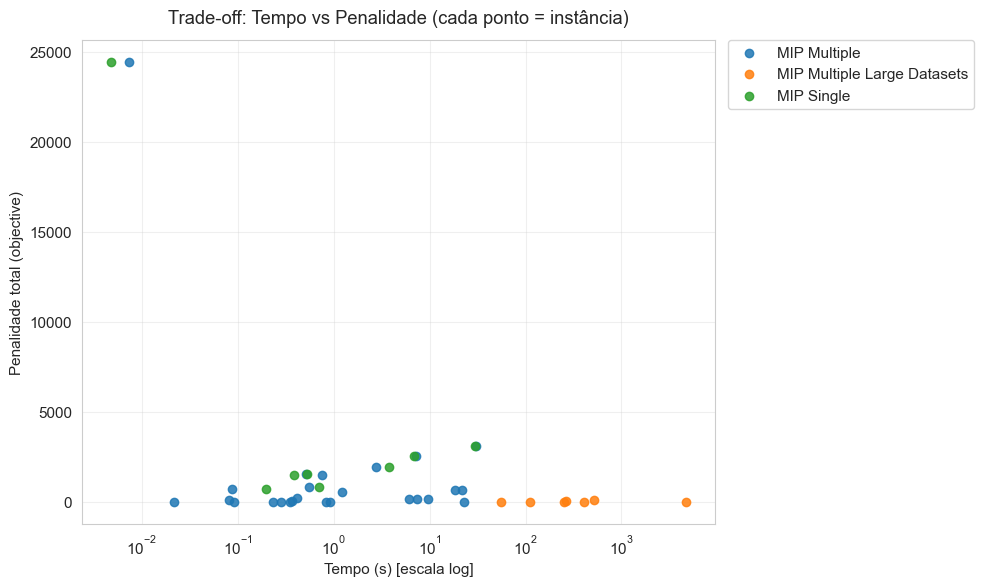

In [39]:
plot_df = df_core.dropna(subset=["wall_time_s", "total_penalty"]).copy()

fig, ax = plt.subplots()

# desenha um conjunto por model_key (fica logo legível)
for model_key, g in plot_df.groupby("model_key"):
    ax.scatter(g["wall_time_s"], g["total_penalty"], label=model_key, alpha=0.85)

ax.set_xscale("log")
ax.set_xlabel("Tempo (s) [escala log]")
ax.set_ylabel("Penalidade total (objective)")
ax.set_title("Trade-off: Tempo vs Penalidade (cada ponto = instância)")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\3283987379.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=models, showfliers=True)


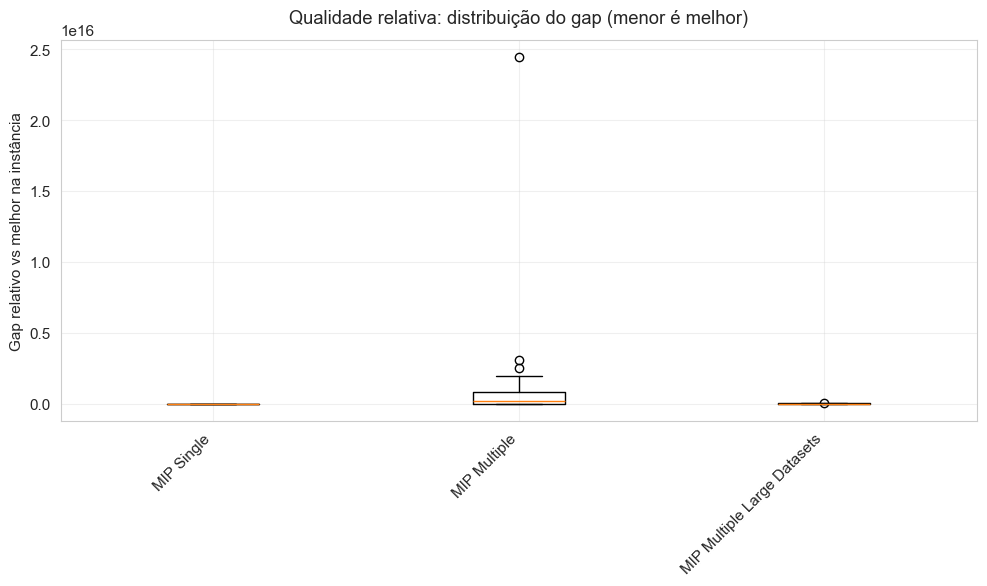

In [40]:
plot_df = df_core.dropna(subset=["relative_gap"]).copy()

# opcional: ignora gaps absurdos se houver falhas/NaNs estranhas
plot_df = plot_df[np.isfinite(plot_df["relative_gap"])]

models = list(plot_df["model_key"].unique())
data = [plot_df.loc[plot_df["model_key"] == m, "relative_gap"].values for m in models]

fig, ax = plt.subplots()
ax.boxplot(data, labels=models, showfliers=True)
ax.set_ylabel("Gap relativo vs melhor na instância")
ax.set_title("Qualidade relativa: distribuição do gap (menor é melhor)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


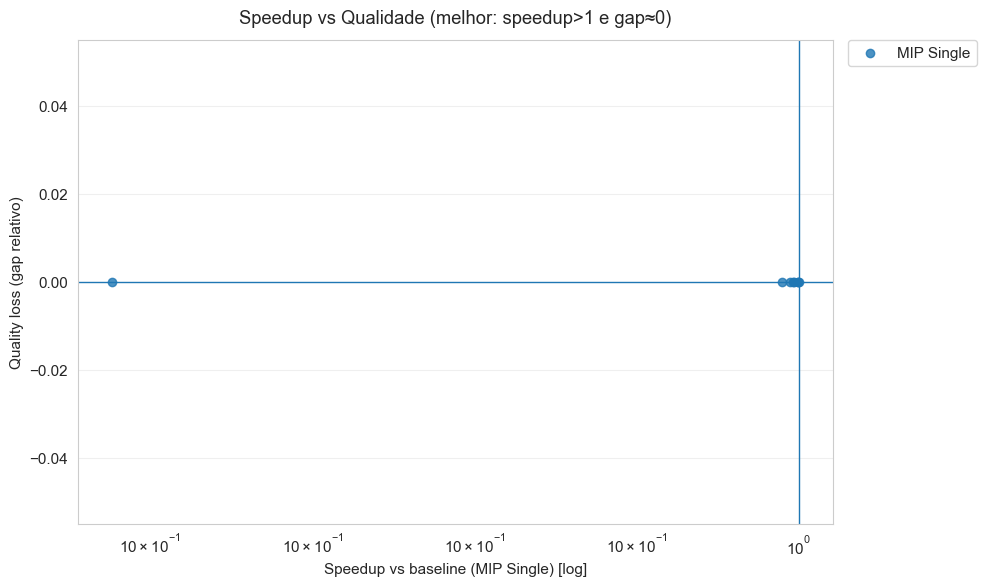

In [41]:
plot_df = df_core.dropna(subset=["wall_time_s", "relative_gap"]).copy()

# baseline: escolhe um model_key existente (ajusta se necessário)
baseline_key = plot_df["model_key"].unique()[0]  # ou mete: "MIP Single" etc.

base = plot_df[plot_df["model_key"] == baseline_key][["instance_id", "wall_time_s"]].rename(
    columns={"wall_time_s": "baseline_time"}
)

plot_df = plot_df.merge(base, on="instance_id", how="left")
plot_df = plot_df.dropna(subset=["baseline_time"])

plot_df["speedup"] = plot_df["baseline_time"] / (plot_df["wall_time_s"] + 1e-12)
plot_df["quality_loss"] = plot_df["relative_gap"]

fig, ax = plt.subplots()
for model_key, g in plot_df.groupby("model_key"):
    ax.scatter(g["speedup"], g["quality_loss"], label=model_key, alpha=0.8)

ax.axvline(1.0, linewidth=1)
ax.axhline(0.0, linewidth=1)

ax.set_xscale("log")
ax.set_xlabel(f"Speedup vs baseline ({baseline_key}) [log]")
ax.set_ylabel("Quality loss (gap relativo)")
ax.set_title("Speedup vs Qualidade (melhor: speedup>1 e gap≈0)")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


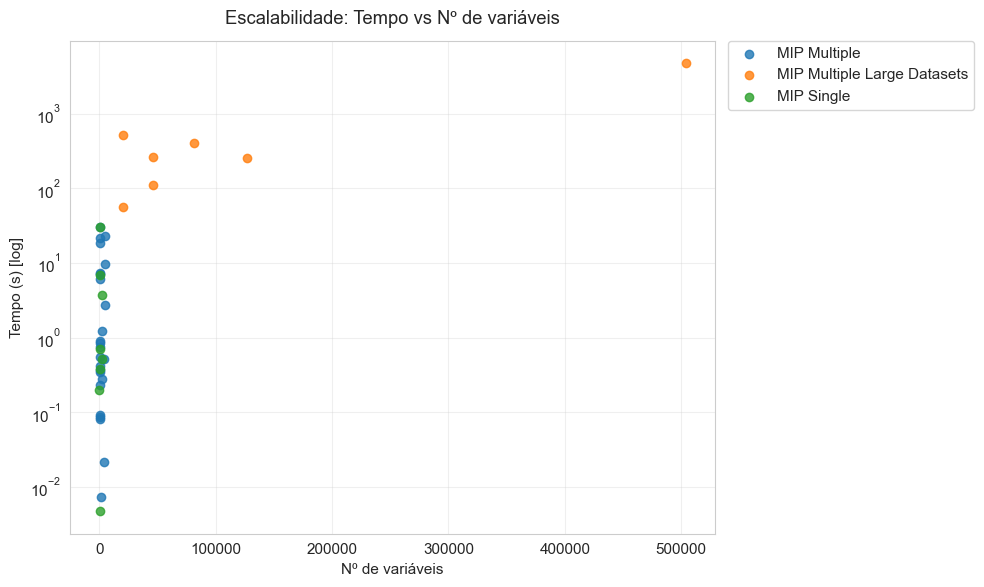

In [42]:
plot_df = df_core.dropna(subset=["num_variables", "wall_time_s"]).copy()

fig, ax = plt.subplots()
for model_key, g in plot_df.groupby("model_key"):
    ax.scatter(g["num_variables"], g["wall_time_s"], label=model_key, alpha=0.8)

ax.set_yscale("log")
ax.set_xlabel("Nº de variáveis")
ax.set_ylabel("Tempo (s) [log]")
ax.set_title("Escalabilidade: Tempo vs Nº de variáveis")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


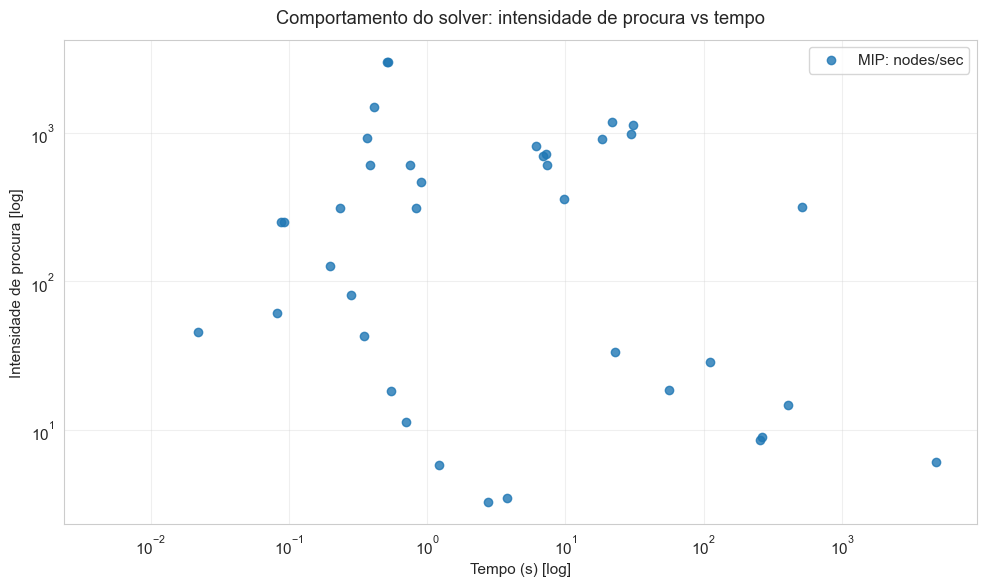

In [43]:
fig, ax = plt.subplots()

mip_df = df_core.dropna(subset=["mip_nodes_per_sec"]).copy()
cp_df  = df_core.dropna(subset=["cp_branches_per_sec"]).copy()

if len(mip_df) > 0:
    ax.scatter(mip_df["wall_time_s"], mip_df["mip_nodes_per_sec"], label="MIP: nodes/sec", alpha=0.8)

if len(cp_df) > 0:
    ax.scatter(cp_df["wall_time_s"], cp_df["cp_branches_per_sec"], label="CP: branches/sec", alpha=0.8)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Tempo (s) [log]")
ax.set_ylabel("Intensidade de procura [log]")
ax.set_title("Comportamento do solver: intensidade de procura vs tempo")

ax.legend()
plt.tight_layout()
plt.show()


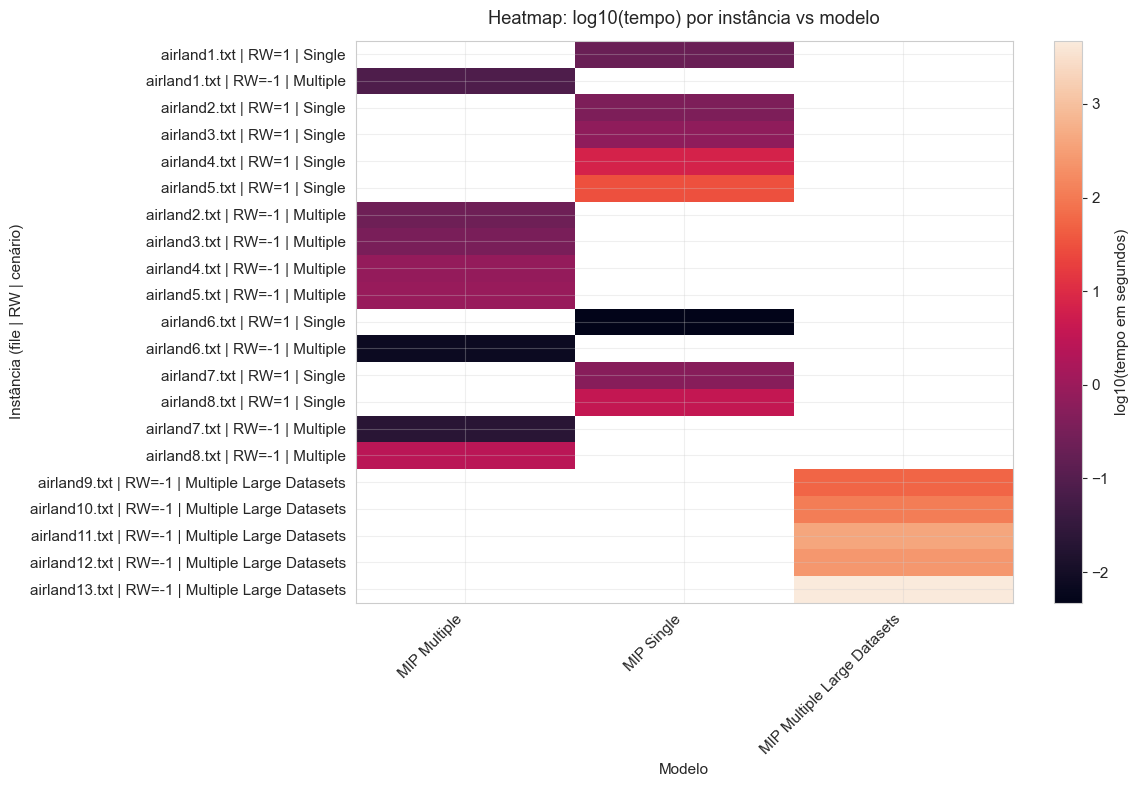

In [44]:
# Usa pivot_time já calculado
heat = pivot_time.copy()

# ordena colunas por tempo mediano (melhor à esquerda)
col_order = heat.median(axis=0, skipna=True).sort_values().index
heat = heat[col_order]

# log para comprimir escala
heat_log = np.log10(heat.to_numpy(dtype=float) + 1e-12)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(heat_log, aspect="auto")

ax.set_title("Heatmap: log10(tempo) por instância vs modelo")
ax.set_xlabel("Modelo")
ax.set_ylabel("Instância (file | RW | cenário)")

ax.set_xticks(np.arange(len(col_order)))
ax.set_xticklabels(col_order, rotation=45, ha="right")

# ylabels: só algumas para não ficar ilegível
n = heat.shape[0]
step = max(1, n // 20)
yticks = np.arange(0, n, step)
ax.set_yticks(yticks)
ax.set_yticklabels([heat.index[i] for i in yticks])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("log10(tempo em segundos)")

plt.tight_layout()
plt.show()


In [45]:
plot_df = df_core[df_core["scenario"].str.contains("Multiple", case=False, na=False)].copy()
plot_df = plot_df[plot_df["runways"] >= 1].dropna(subset=["runways", "wall_time_s"])

if len(plot_df) == 0:
    print("Não há dados de Multiple com runways>=1 neste dataset.")
else:
    fig, ax = plt.subplots()

    # mostra a mediana por (model_key, runways)
    agg = (
        plot_df.groupby(["model_key", "runways"])["wall_time_s"]
               .median()
               .reset_index()
               .sort_values(["model_key", "runways"])
    )

    for model_key, g in agg.groupby("model_key"):
        ax.plot(g["runways"], g["wall_time_s"], marker="o", label=model_key)

    ax.set_yscale("log")
    ax.set_xlabel("Nº de runways")
    ax.set_ylabel("Tempo mediano (s) [log]")
    ax.set_title("Multiple: tempo vs nº de runways (mediana por runways)")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


Não há dados de Multiple com runways>=1 neste dataset.


# OUTRO

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def metric_col(df, preferred, fallback=None):
    """
    Devolve a coluna preferred se existir e tiver valores,
    senão tenta fallback. (Não cria métricas novas)
    """
    if preferred in df.columns and df[preferred].notna().any():
        return preferred
    if fallback and fallback in df.columns and df[fallback].notna().any():
        return fallback
    raise ValueError(f"Não há dados para {preferred} (nem fallback={fallback}).")


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\4129089728.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


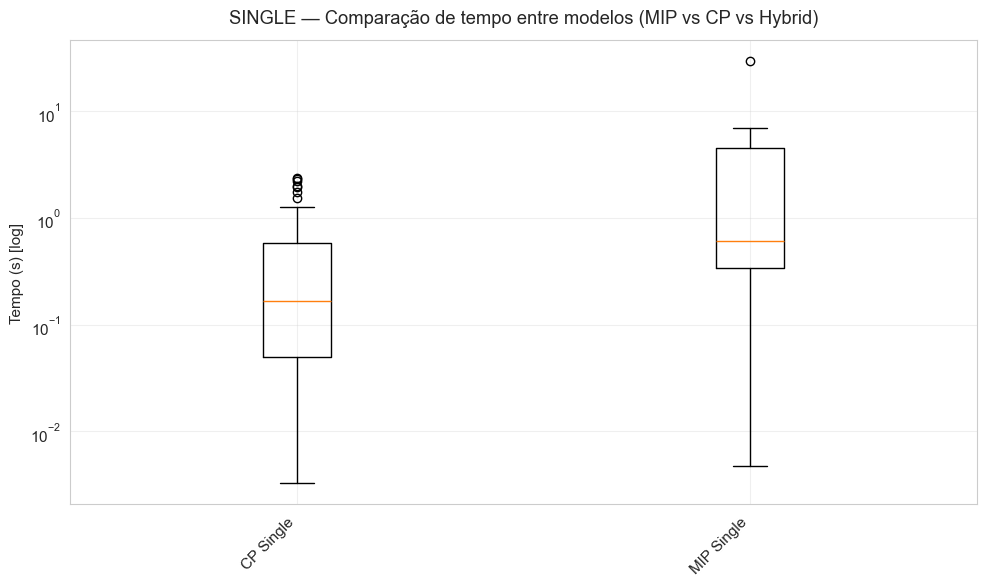

In [47]:
single = df[df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)].copy()

time_col = metric_col(single, "wall_time_s", "execution_time")  # usa o que existir
single = single.dropna(subset=[time_col])

labels = []
data = []
for mk, g in single.groupby("model_key"):
    labels.append(mk)
    data.append(g[time_col].values)

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data, labels=labels, showfliers=True)
ax.set_yscale("log")
ax.set_ylabel("Tempo (s) [log]")
ax.set_title("SINGLE — Comparação de tempo entre modelos (MIP vs CP vs Hybrid)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\704605376.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


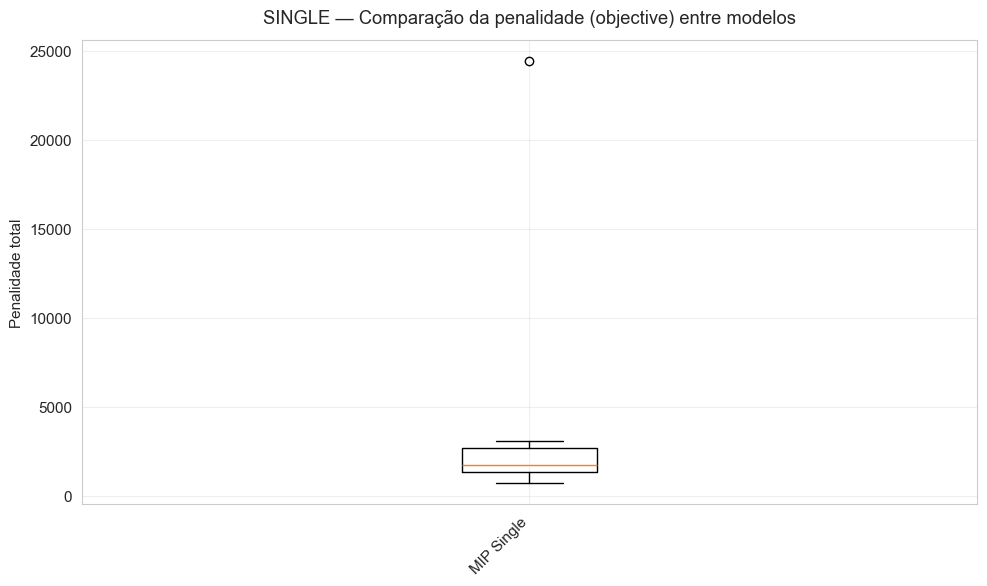

In [48]:
single_obj = single.dropna(subset=["total_penalty"]).copy()

labels, data = [], []
for mk, g in single_obj.groupby("model_key"):
    labels.append(mk)
    data.append(g["total_penalty"].values)

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data, labels=labels, showfliers=True)
ax.set_ylabel("Penalidade total")
ax.set_title("SINGLE — Comparação da penalidade (objective) entre modelos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


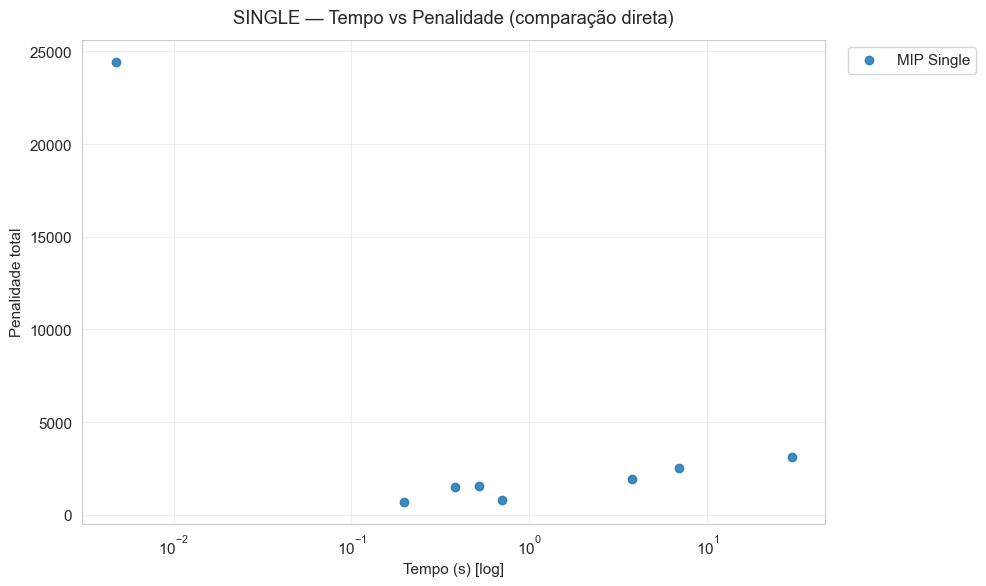

In [49]:
single_sc = df[df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)].copy()
time_col = metric_col(single_sc, "wall_time_s", "execution_time")
single_sc = single_sc.dropna(subset=[time_col, "total_penalty"])

fig, ax = plt.subplots(figsize=(10, 6))
for mk, g in single_sc.groupby("model_key"):
    ax.scatter(g[time_col], g["total_penalty"], label=mk, alpha=0.85)

ax.set_xscale("log")
ax.set_xlabel("Tempo (s) [log]")
ax.set_ylabel("Penalidade total")
ax.set_title("SINGLE — Tempo vs Penalidade (comparação direta)")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\525134831.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


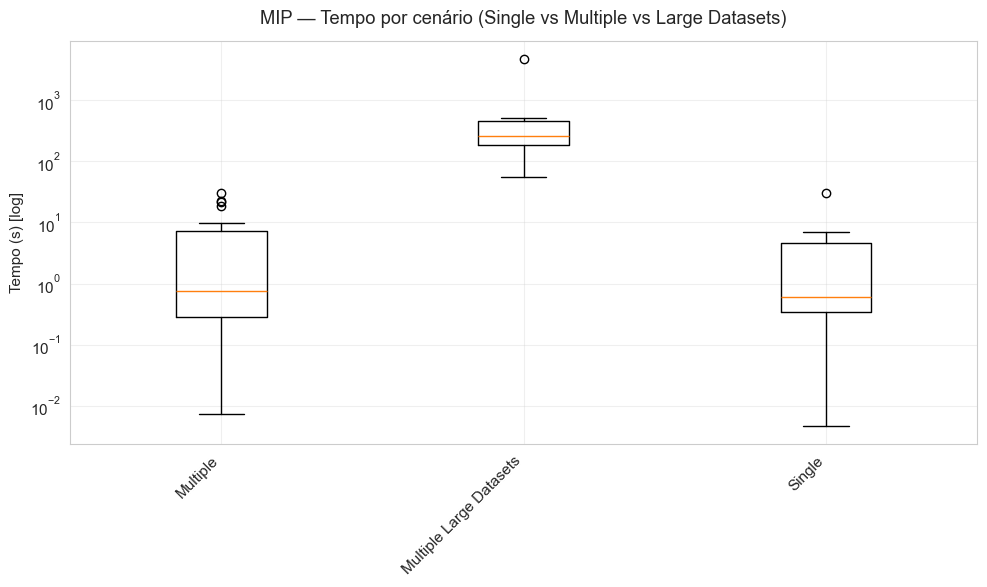

C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\525134831.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


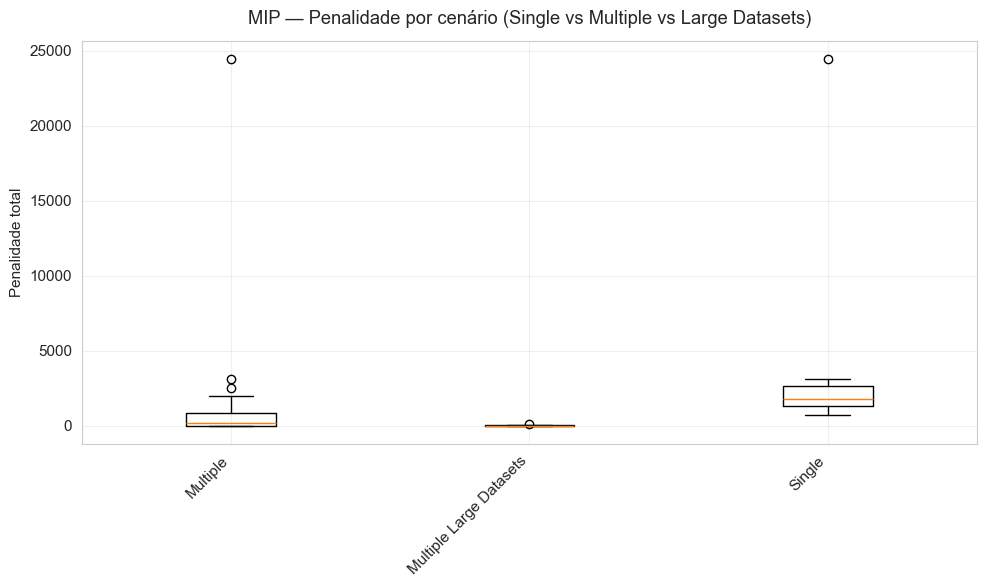

In [50]:
mip = df[df["model_family"].str.upper().eq("MIP")].copy()
time_col = metric_col(mip, "wall_time_s", "execution_time")

# tempo por cenário
mip_t = mip.dropna(subset=[time_col])
labels, data = [], []
for scen, g in mip_t.groupby("scenario"):
    labels.append(scen)
    data.append(g[time_col].values)

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data, labels=labels, showfliers=True)
ax.set_yscale("log")
ax.set_ylabel("Tempo (s) [log]")
ax.set_title("MIP — Tempo por cenário (Single vs Multiple vs Large Datasets)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# penalidade por cenário
mip_p = mip.dropna(subset=["total_penalty"])
labels, data = [], []
for scen, g in mip_p.groupby("scenario"):
    labels.append(scen)
    data.append(g["total_penalty"].values)

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data, labels=labels, showfliers=True)
ax.set_ylabel("Penalidade total")
ax.set_title("MIP — Penalidade por cenário (Single vs Multiple vs Large Datasets)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [51]:
multi = df[df["scenario"].str.contains("Multiple", case=False, na=False)].copy()
time_col = metric_col(multi, "wall_time_s", "execution_time")
multi = multi.dropna(subset=["runways", time_col])
multi = multi[multi["runways"] >= 1]

if len(multi) == 0:
    print("Não há dados com runways (>=1) para Multiple neste JSON.")
else:
    fig, ax = plt.subplots(figsize=(10, 6))

    # mediana por (modelo, runways)
    agg = (multi.groupby(["model_key", "runways"])[time_col]
                .median()
                .reset_index()
                .sort_values(["model_key", "runways"]))

    for mk, g in agg.groupby("model_key"):
        ax.plot(g["runways"], g[time_col], marker="o", label=mk)

    ax.set_yscale("log")
    ax.set_xlabel("Nº de runways")
    ax.set_ylabel("Tempo mediano (s) [log]")
    ax.set_title("MULTIPLE — Tempo vs Nº de runways (mediana)")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


Não há dados com runways (>=1) para Multiple neste JSON.


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\680448723.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


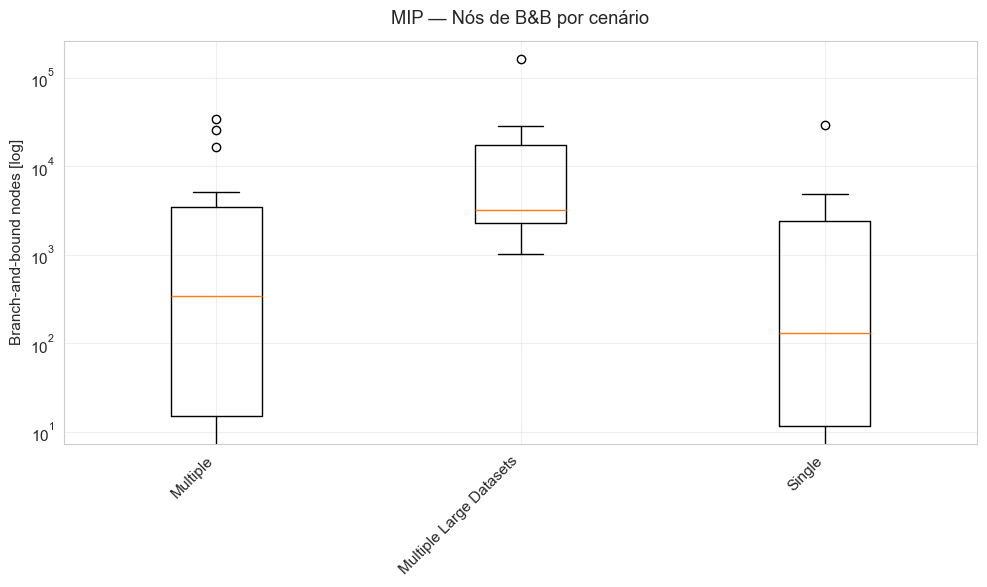

In [52]:
mip = df[df["model_family"].str.upper().eq("MIP")].copy()
if "num_branch_and_bound_nodes" not in mip.columns or not mip["num_branch_and_bound_nodes"].notna().any():
    print("MIP: não há num_branch_and_bound_nodes no dataset.")
else:
    mip_n = mip.dropna(subset=["num_branch_and_bound_nodes"])
    labels, data = [], []
    for scen, g in mip_n.groupby("scenario"):
        labels.append(scen)
        data.append(g["num_branch_and_bound_nodes"].values)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(data, labels=labels, showfliers=True)
    ax.set_yscale("log")
    ax.set_ylabel("Branch-and-bound nodes [log]")
    ax.set_title("MIP — Nós de B&B por cenário")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\4114308628.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


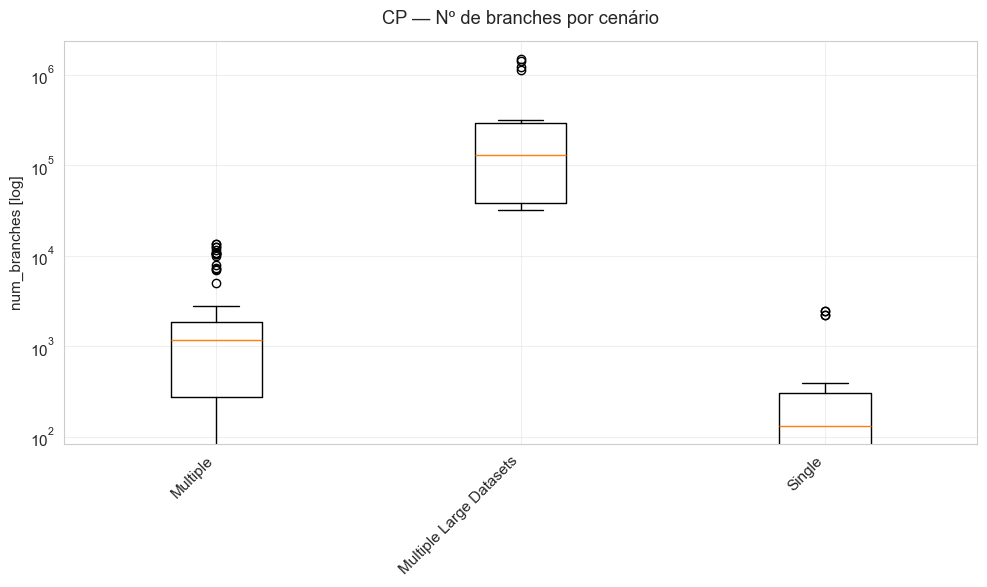

C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\4114308628.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


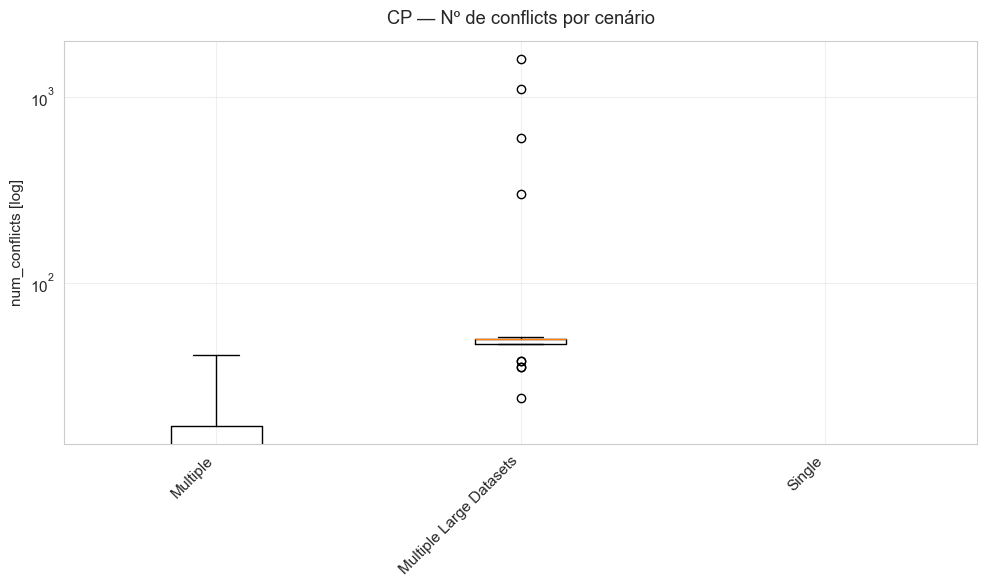

In [53]:
cp = df[df["model_family"].str.upper().eq("CP")].copy()

for col, title, logy in [
    ("num_branches", "CP — Nº de branches por cenário", True),
    ("num_conflicts", "CP — Nº de conflicts por cenário", True),
]:
    if col not in cp.columns or not cp[col].notna().any():
        print(f"CP: não há {col} no dataset.")
        continue

    cpdf = cp.dropna(subset=[col])
    labels, data = [], []
    for scen, g in cpdf.groupby("scenario"):
        labels.append(scen)
        data.append(g[col].values)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(data, labels=labels, showfliers=True)
    if logy:
        ax.set_yscale("log")
        ax.set_ylabel(f"{col} [log]")
    else:
        ax.set_ylabel(col)
    ax.set_title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



==================== Small/Medium Datasets (Airland 1-8) ====================



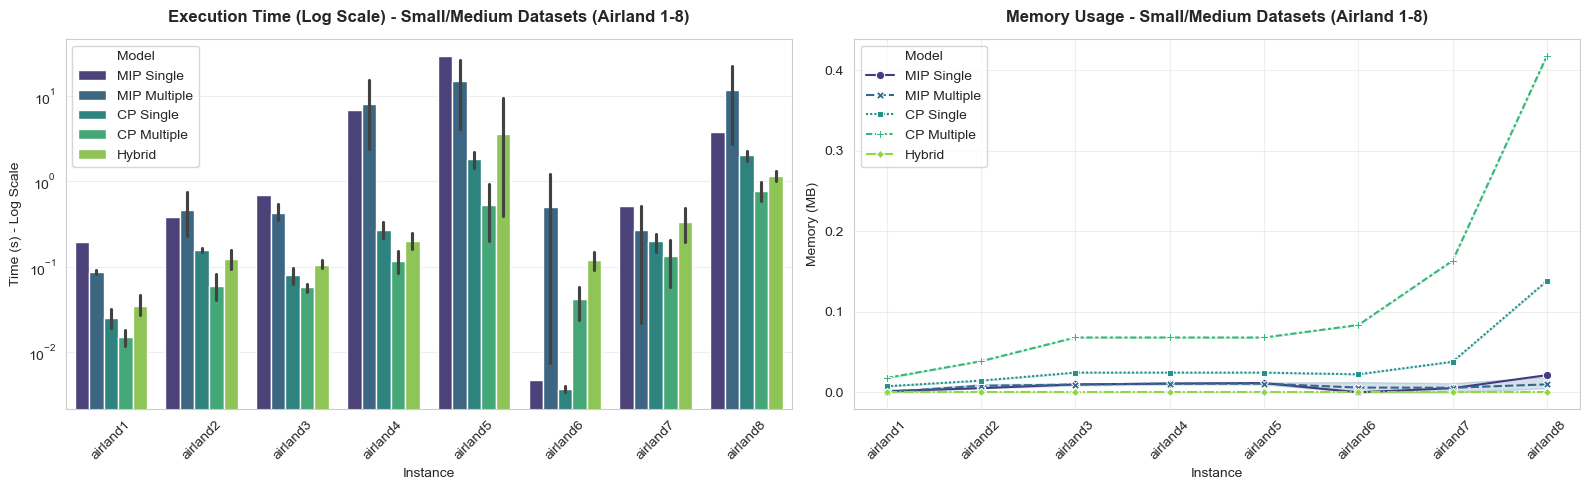

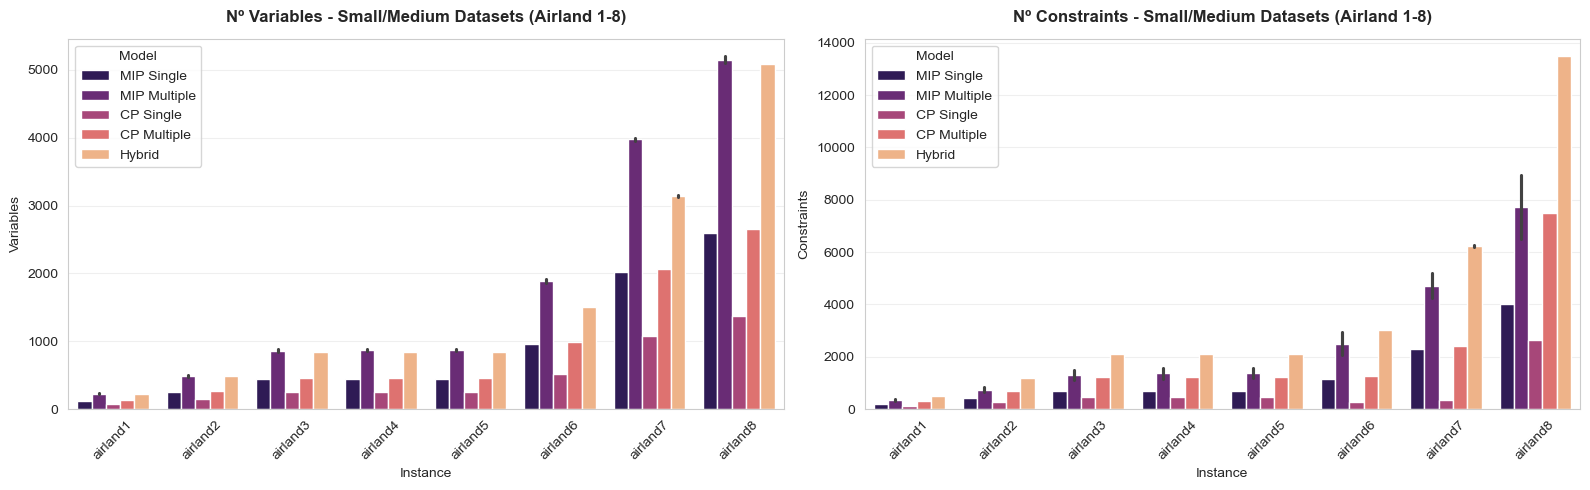

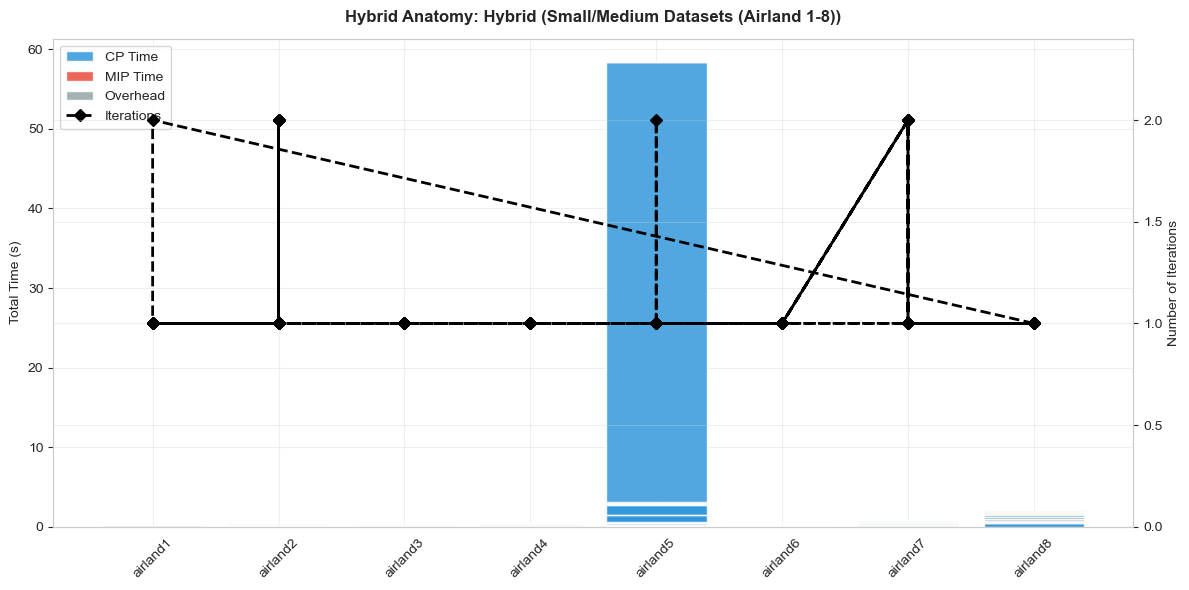


==================== Large Datasets (Airland 9-13) ====================



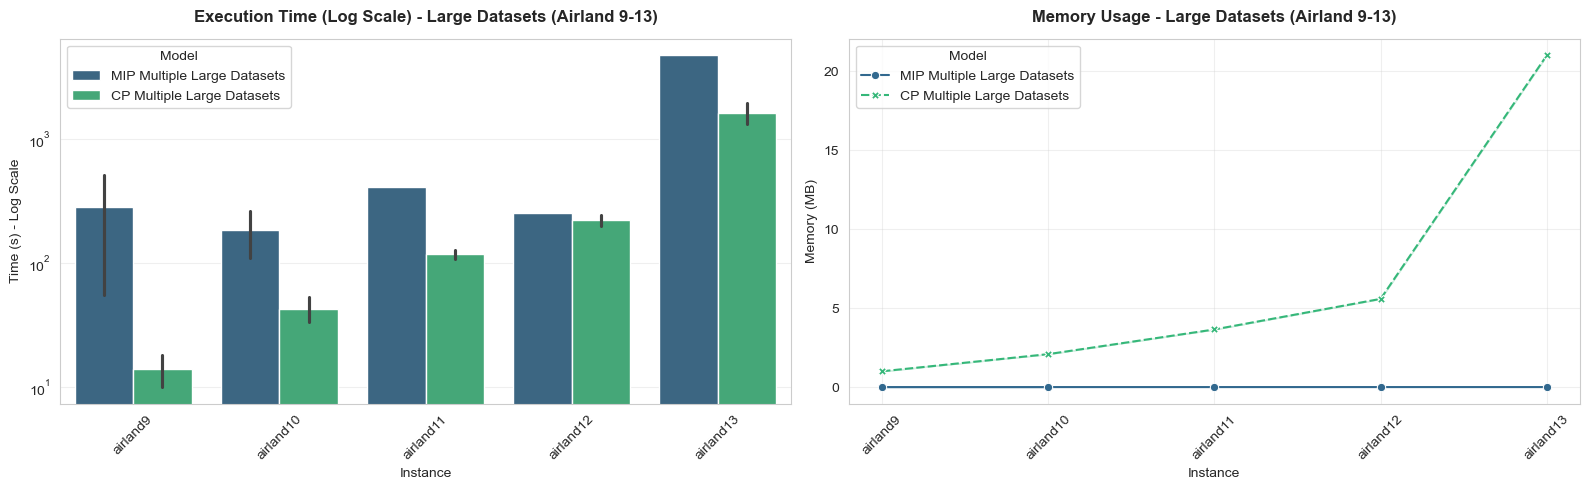

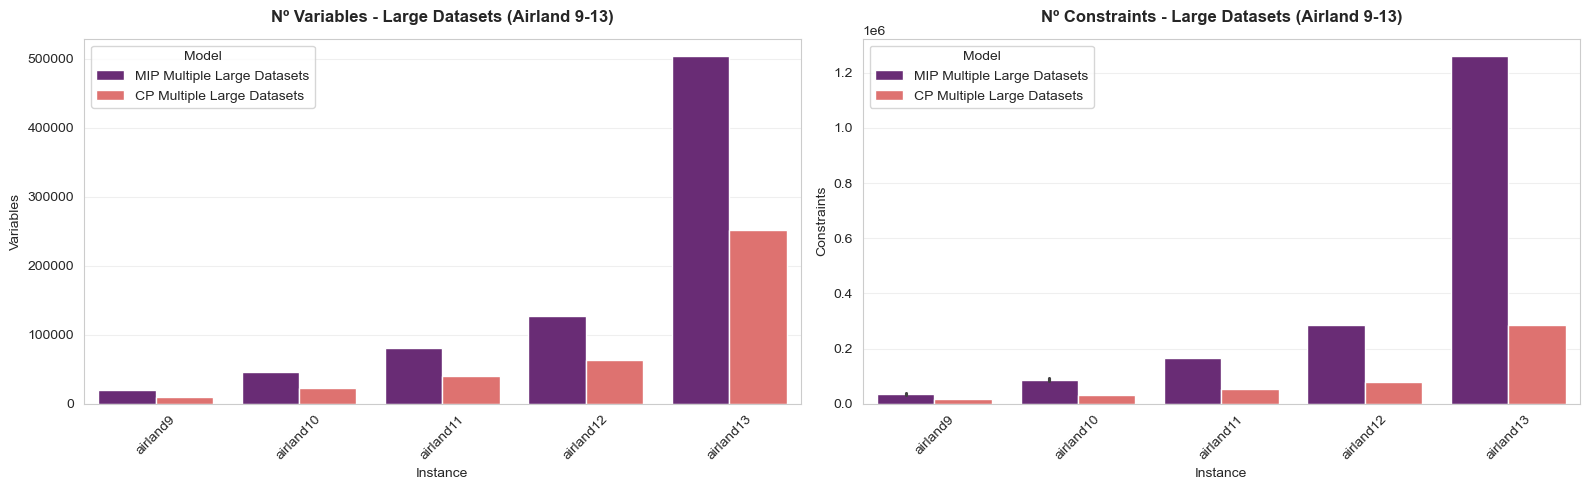

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import re

# Garante que os gráficos aparecem no notebook
%matplotlib inline 

# Configuração de estilo para ficar bonito no notebook
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 10

# ---------------------------------------------------------
# 1. CARREGAR E PROCESSAR DADOS
# ---------------------------------------------------------
# Substitui pelo caminho do teu ficheiro real
with open('results/metrics.json', 'r') as f:
    data = json.load(f)

rows = []
hybrid_rows = []

for model_name, instances in data.items():
    for inst in instances:
        file_name = inst.get("file", "")
        # Extrair o número do ficheiro (ex: "airland1.txt" -> 1)
        # Usa regex para apanhar apenas os dígitos
        match = re.search(r'\d+', file_name)
        instance_id = int(match.group()) if match else 0
        
        # Dados Gerais
        exec_time = inst.get("execution_time") or inst.get("total_time", 0)
        mem_usage = inst.get("memory_usage_MB") or inst.get("memory_usage", 0)
        n_vars = inst.get("num_variables", inst.get("cp_num_variables", 0))
        n_cons = inst.get("num_constraints", inst.get("cp_num_constraints", 0))
        
        rows.append({
            "Model": model_name,
            "Instance": file_name.replace(".txt", ""),
            "ID": instance_id,
            "Time (s)": exec_time,
            "Memory (MB)": mem_usage,
            "Variables": n_vars,
            "Constraints": n_cons
        })
        
        # Dados Específicos do Hybrid para o gráfico detalhado
        if "Hybrid" in model_name:
            cp_time = inst.get("cp_time", 0)
            mip_time = inst.get("mip_time", 0)
            total_time = inst.get("total_time", exec_time)
            
            hybrid_rows.append({
                "Instance": file_name.replace(".txt", ""),
                "ID": instance_id,
                "Model Variant": model_name,
                "CP Time": cp_time,
                "MIP Time": mip_time,
                "Overhead": max(0, total_time - cp_time - mip_time),
                "Iterations": inst.get("num_iterations", 0)
            })

df_all = pd.DataFrame(rows)
df_hybrid_all = pd.DataFrame(hybrid_rows)

# ---------------------------------------------------------
# 2. FUNÇÃO DE PLOTAGEM (Reutilizável)
# ---------------------------------------------------------
def plot_group_metrics(df_subset, df_hybrid_subset, group_title):
    if df_subset.empty:
        print(f"⚠️ Sem dados para o grupo: {group_title}")
        return

    print(f"\n{'='*20} {group_title} {'='*20}\n")

    # --- GRÁFICO 1: TEMPO E MEMÓRIA ---
    fig1, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Tempo (Log Scale porque a diferença entre airland1 e 8 é gigante)
    sns.barplot(data=df_subset, x="Instance", y="Time (s)", hue="Model", ax=axes[0], palette="viridis")
    axes[0].set_yscale("log")
    axes[0].set_title(f"Execution Time (Log Scale) - {group_title}", fontweight='bold')
    axes[0].set_ylabel("Time (s) - Log Scale")
    axes[0].tick_params(axis='x', rotation=45)
    
    # Memória
    sns.lineplot(data=df_subset, x="Instance", y="Memory (MB)", hue="Model", style="Model", markers=True, ax=axes[1], palette="viridis")
    axes[1].set_title(f"Memory Usage - {group_title}", fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show() # Display inline
    
    # --- GRÁFICO 2: COMPLEXIDADE (Variáveis vs Restrições) ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 5))
    
    sns.barplot(data=df_subset, x="Instance", y="Variables", hue="Model", ax=axes2[0], palette="magma")
    axes2[0].set_title(f"Nº Variables - {group_title}", fontweight='bold')
    axes2[0].tick_params(axis='x', rotation=45)
    
    sns.barplot(data=df_subset, x="Instance", y="Constraints", hue="Model", ax=axes2[1], palette="magma")
    axes2[1].set_title(f"Nº Constraints - {group_title}", fontweight='bold')
    axes2[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show() # Display inline

    # --- GRÁFICO 3: HYBRID ANATOMY (Só se houver dados Hybrid neste grupo) ---
    if not df_hybrid_subset.empty:
        # Agrupa por variante se houver mais que um hybrid
        variants = df_hybrid_subset["Model Variant"].unique()
        
        for var in variants:
            subset = df_hybrid_subset[df_hybrid_subset["Model Variant"] == var]
            
            fig3, ax3 = plt.subplots(figsize=(12, 6))
            
            x = subset["Instance"]
            # Stacked Bar manual
            p1 = ax3.bar(x, subset["CP Time"], label="CP Time", color="#3498db", alpha=0.85)
            p2 = ax3.bar(x, subset["MIP Time"], bottom=subset["CP Time"], label="MIP Time", color="#e74c3c", alpha=0.85)
            # O Overhead é colocado em cima da soma CP+MIP
            p3 = ax3.bar(x, subset["Overhead"], bottom=subset["CP Time"] + subset["MIP Time"], label="Overhead", color="#95a5a6", alpha=0.85)
            
            # Eixo secundário para iterações
            ax_twin = ax3.twinx()
            ax_twin.plot(x, subset["Iterations"], color="black", marker="D", linestyle="--", linewidth=2, label="Iterations")
            ax_twin.set_ylabel("Number of Iterations")
            # Ajusta limite para ficar bonito
            ax_twin.set_ylim(0, subset["Iterations"].max() * 1.2 if subset["Iterations"].max() > 0 else 5)
            
            ax3.set_title(f"Hybrid Anatomy: {var} ({group_title})", fontweight='bold')
            ax3.set_ylabel("Total Time (s)")
            ax3.tick_params(axis='x', rotation=45)
            
            # Legenda combinada
            lines, labels = ax3.get_legend_handles_labels()
            lines2, labels2 = ax_twin.get_legend_handles_labels()
            ax3.legend(lines + lines2, labels + labels2, loc="upper left")
            
            plt.tight_layout()
            plt.show() # Display inline

# ---------------------------------------------------------
# 3. EXECUTAR A DIVISÃO
# ---------------------------------------------------------

# Grupo 1: Airland 1 ao 8
mask_small = (df_all["ID"] >= 1) & (df_all["ID"] <= 8)
df_small = df_all[mask_small]
# Filtra também o dataframe de detalhe hybrid
if not df_hybrid_all.empty:
    df_hybrid_small = df_hybrid_all[(df_hybrid_all["ID"] >= 1) & (df_hybrid_all["ID"] <= 8)]
else:
    df_hybrid_small = pd.DataFrame()

plot_group_metrics(df_small, df_hybrid_small, "Small/Medium Datasets (Airland 1-8)")


# Grupo 2: Airland 9 ao 13
mask_large = (df_all["ID"] >= 9) & (df_all["ID"] <= 13)
df_large = df_all[mask_large]
if not df_hybrid_all.empty:
    df_hybrid_large = df_hybrid_all[(df_hybrid_all["ID"] >= 9) & (df_hybrid_all["ID"] <= 13)]
else:
    df_hybrid_large = pd.DataFrame()

plot_group_metrics(df_large, df_hybrid_large, "Large Datasets (Airland 9-13)")


==================== Small/Medium Datasets (Airland 1-8) ====================



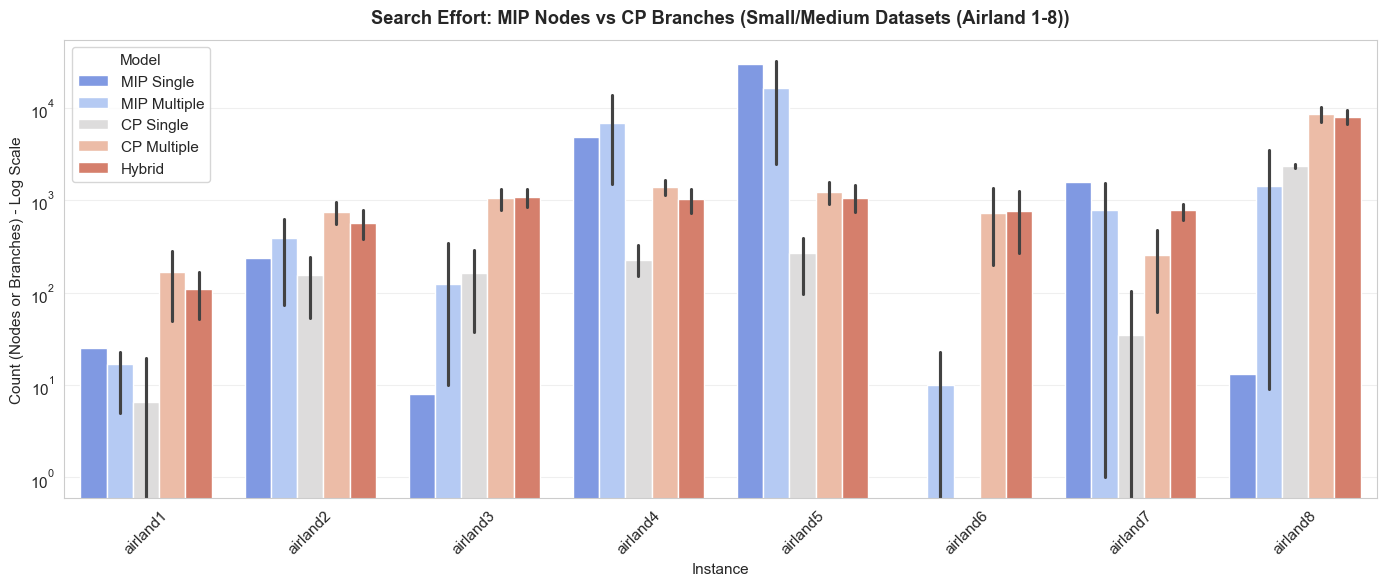

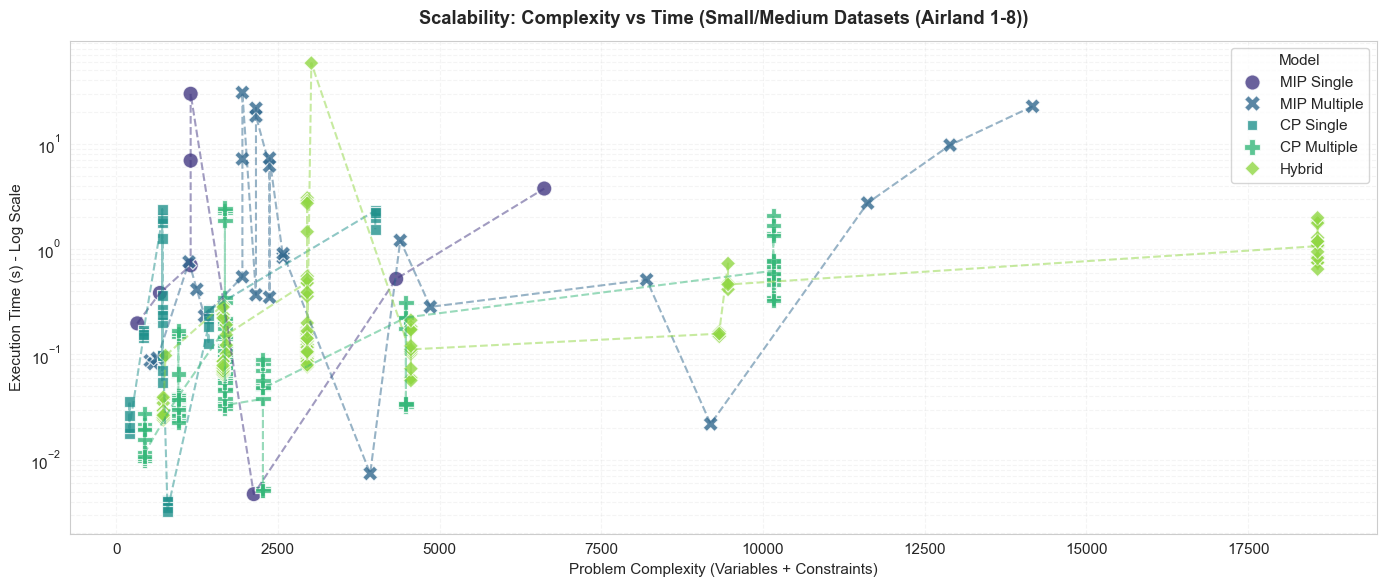


==================== Large Datasets (Airland 9-13) ====================



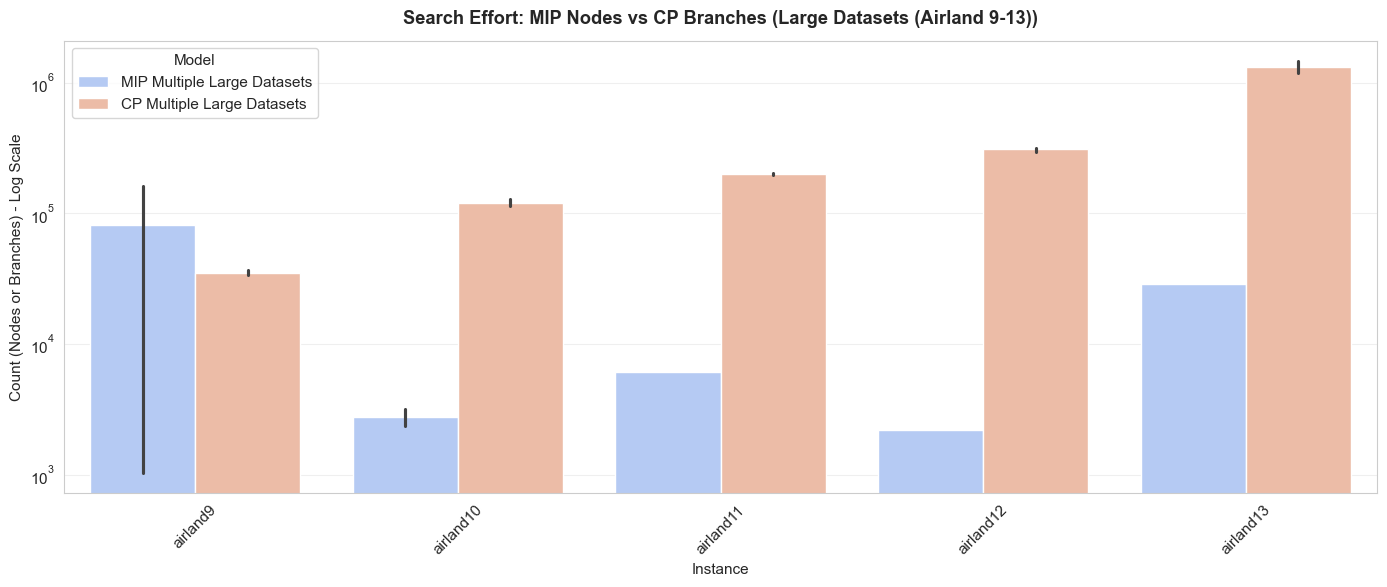

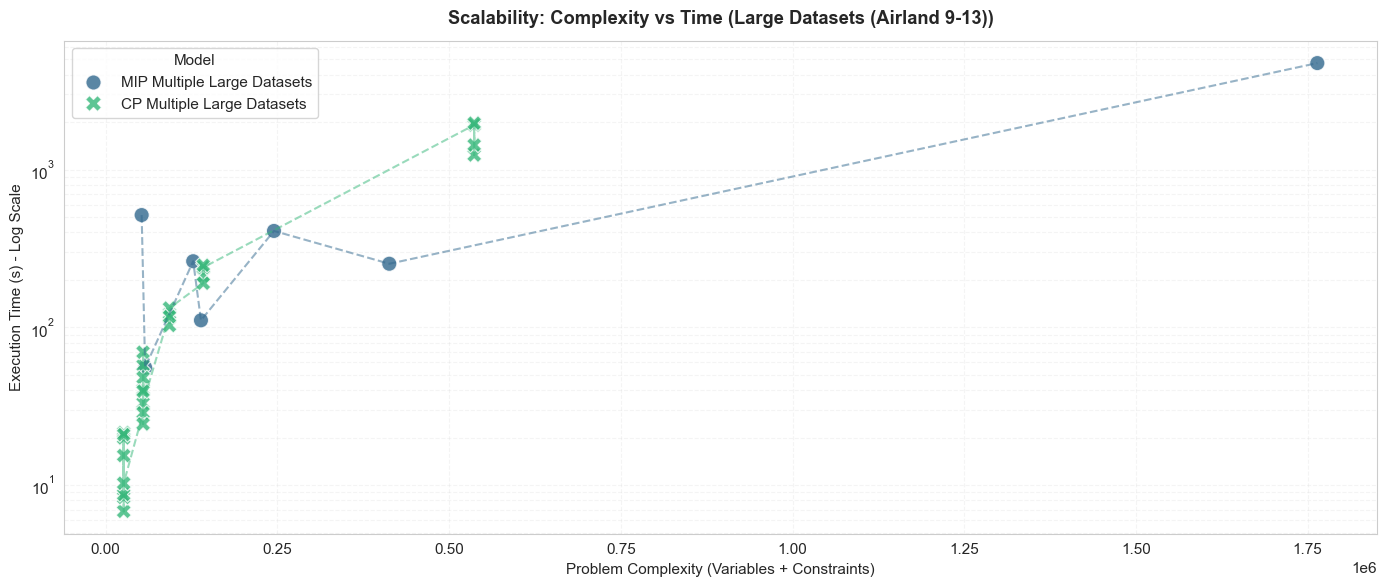

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import re
import numpy as np

%matplotlib inline 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# ---------------------------------------------------------
# 1. CARREGAR E PROCESSAR DADOS
# ---------------------------------------------------------
# Ajusta o path se necessário
with open('results/metrics.json', 'r') as f:
    data = json.load(f)

rows = []

for model_name, instances in data.items():
    for inst in instances:
        file_name = inst.get("file", "").replace(".txt", "")
        match = re.search(r'\d+', file_name)
        instance_id = int(match.group()) if match else 0
        
        # Métricas de esforço
        nodes = inst.get("num_branch_and_bound_nodes", 0) # MIP
        branches = inst.get("num_branches", inst.get("cp_num_branches", 0)) # CP & Hybrid
        
        # Métrica unificada
        search_steps = max(nodes, branches)
        
        # Tamanho do problema
        n_vars = inst.get("num_variables", inst.get("cp_num_variables", 0))
        n_cons = inst.get("num_constraints", inst.get("cp_num_constraints", 0))
        problem_size = n_vars + n_cons
        
        exec_time = inst.get("execution_time") or inst.get("total_time", 0)
        
        rows.append({
            "Model": model_name,
            "Instance": file_name,
            "ID": instance_id,
            "Search Steps": search_steps,
            "Problem Size": problem_size,
            "Time (s)": exec_time,
            "Type": "MIP Nodes" if "MIP" in model_name else "CP Branches"
        })

df_all = pd.DataFrame(rows)

# ---------------------------------------------------------
# 2. FUNÇÃO DE PLOTAGEM AVANÇADA
# ---------------------------------------------------------
def plot_advanced_metrics(df_subset, group_title):
    if df_subset.empty:
        print(f"⚠️ Sem dados suficientes para gerar gráficos avançados de: {group_title}")
        return

    print(f"\n{'='*20} {group_title} {'='*20}\n")

    # --- GRÁFICO A: SEARCH EFFORT (Log Scale) ---
    plt.figure(figsize=(14, 6))
    
    # Criamos o barplot
    sns.barplot(data=df_subset, x="Instance", y="Search Steps", hue="Model", palette="coolwarm")
    
    plt.yscale("log") # Escala Logarítmica é essencial aqui
    plt.title(f"Search Effort: MIP Nodes vs CP Branches ({group_title})", fontweight='bold')
    plt.ylabel("Count (Nodes or Branches) - Log Scale")
    plt.xlabel("Instance")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO B: SCALABILITY (Scatter + Trend Lines) ---
    plt.figure(figsize=(14, 6))
    
    # Scatter Plot Principal
    # Definimos uma palette fixa para este grupo para garantir consistência
    unique_models = df_subset["Model"].unique()
    palette = sns.color_palette("viridis", n_colors=len(unique_models))
    
    sns.scatterplot(
        data=df_subset, 
        x="Problem Size", 
        y="Time (s)", 
        hue="Model", 
        style="Model", 
        s=120, 
        alpha=0.8, 
        palette=palette
    )

    # Adicionar linhas de tendência manuais para conectar os pontos do mesmo modelo
    for i, model in enumerate(unique_models):
        subset_model = df_subset[df_subset["Model"] == model].sort_values("Problem Size")
        
        # Só desenhamos linha se houver mais de 1 ponto
        if len(subset_model) > 1:
            plt.plot(
                subset_model["Problem Size"], 
                subset_model["Time (s)"], 
                linestyle="--", 
                alpha=0.5, 
                color=palette[i]
            )

    plt.yscale("log") # Tempo em log
    plt.title(f"Scalability: Complexity vs Time ({group_title})", fontweight='bold')
    plt.xlabel("Problem Complexity (Variables + Constraints)")
    plt.ylabel("Execution Time (s) - Log Scale")
    plt.grid(True, which="both", ls="--", alpha=0.2)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 3. EXECUTAR POR GRUPOS
# ---------------------------------------------------------

# Grupo 1: Datasets Pequenos/Médios (1-8)
df_small = df_all[(df_all["ID"] >= 1) & (df_all["ID"] <= 8)]
plot_advanced_metrics(df_small, "Small/Medium Datasets (Airland 1-8)")

# Grupo 2: Datasets Grandes (9-13)
df_large = df_all[(df_all["ID"] >= 9) & (df_all["ID"] <= 13)]
plot_advanced_metrics(df_large, "Large Datasets (Airland 9-13)")


>>> HEAD-TO-HEAD COMPARISON: Small Datasets <<<



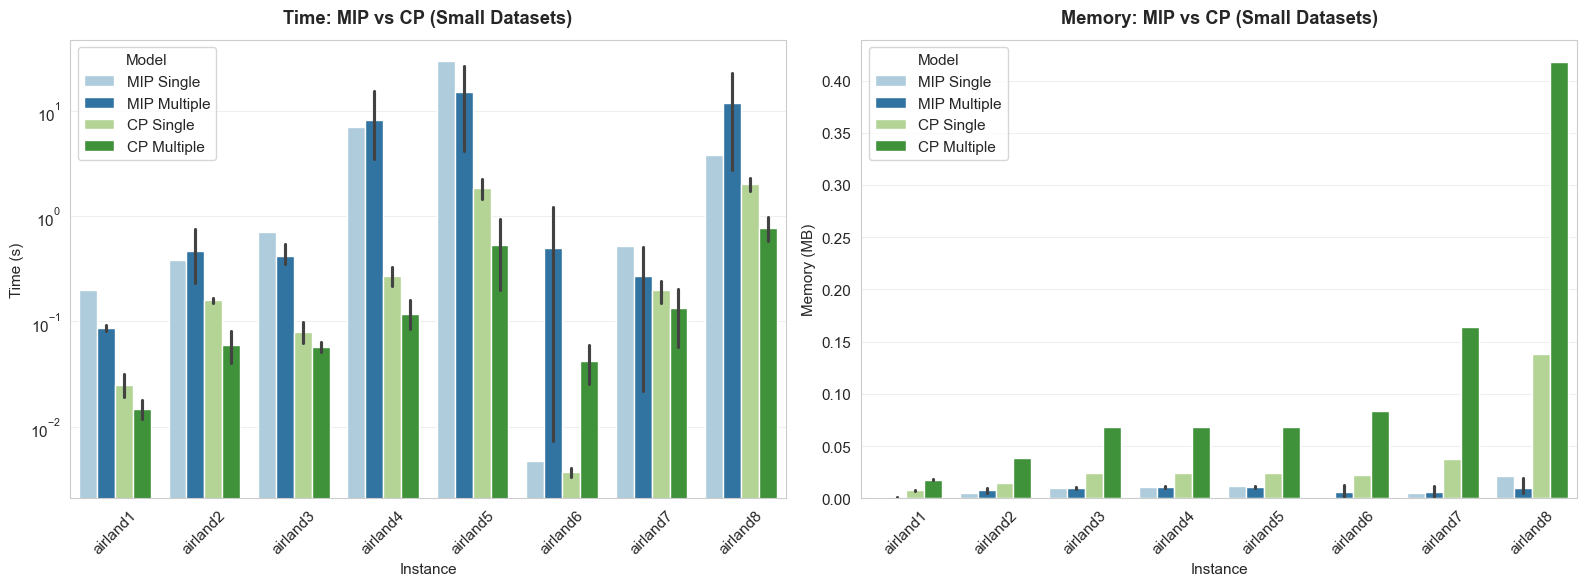


>>> MIP EVOLUTION: Small Datasets <<<



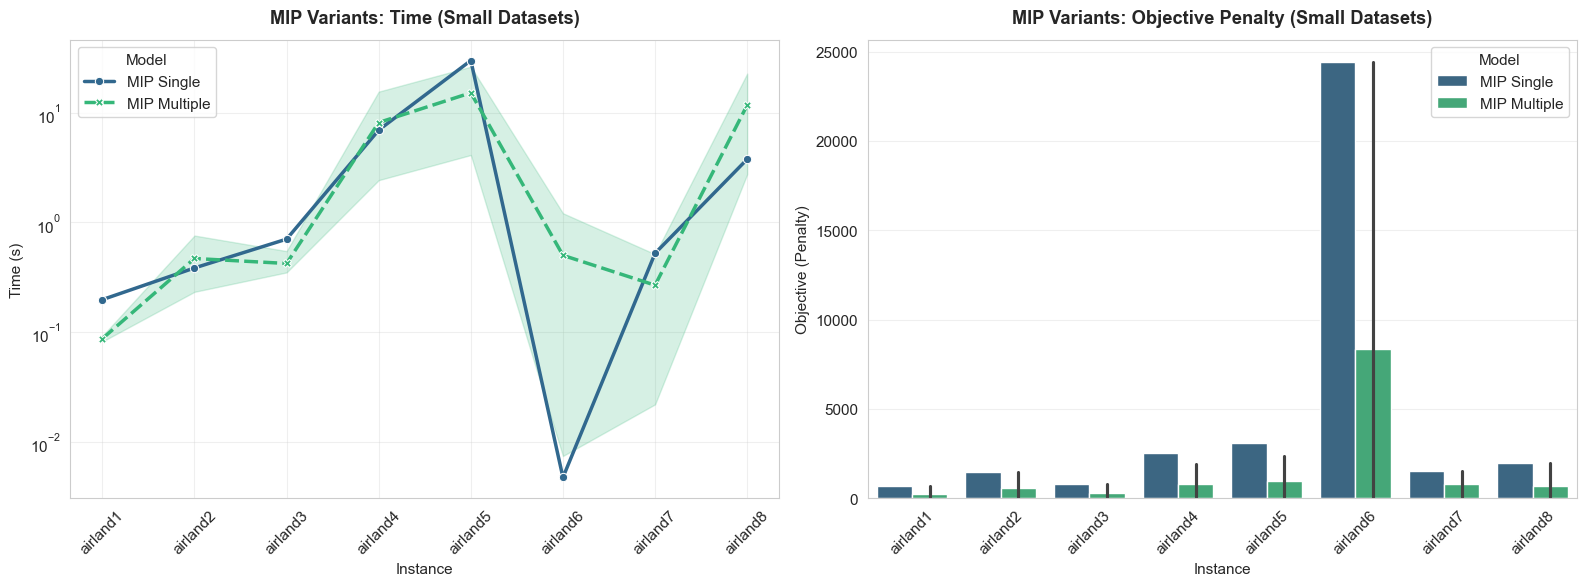


>>> CP EVOLUTION: Small Datasets <<<



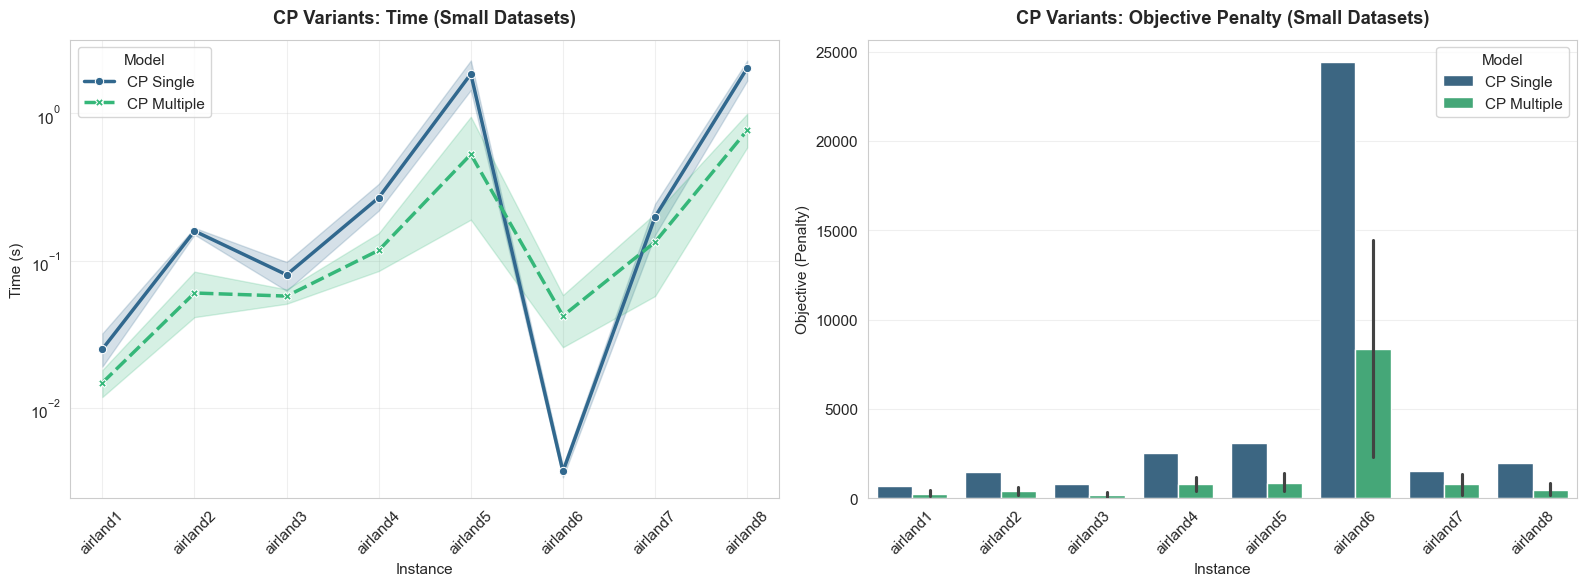


>>> HEAD-TO-HEAD COMPARISON: Large Datasets <<<

Dados insuficientes para Head-to-Head.

>>> MIP EVOLUTION: Large Datasets <<<



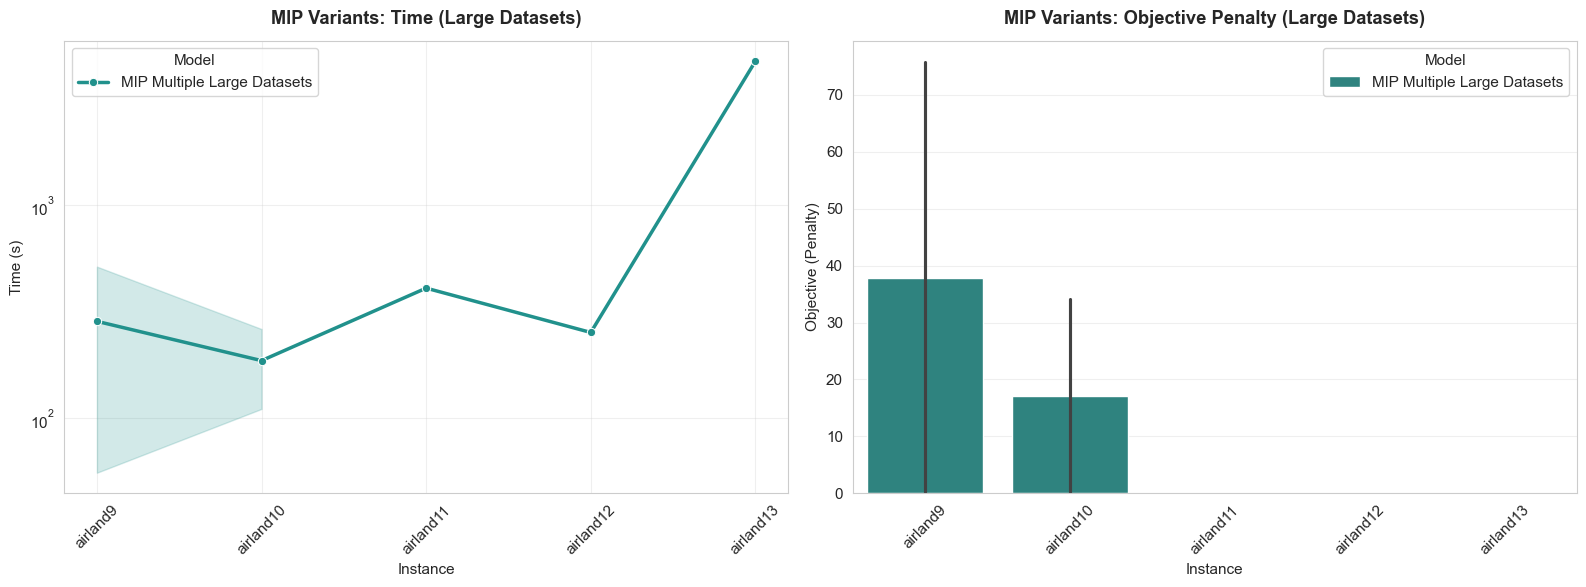


>>> CP EVOLUTION: Large Datasets <<<



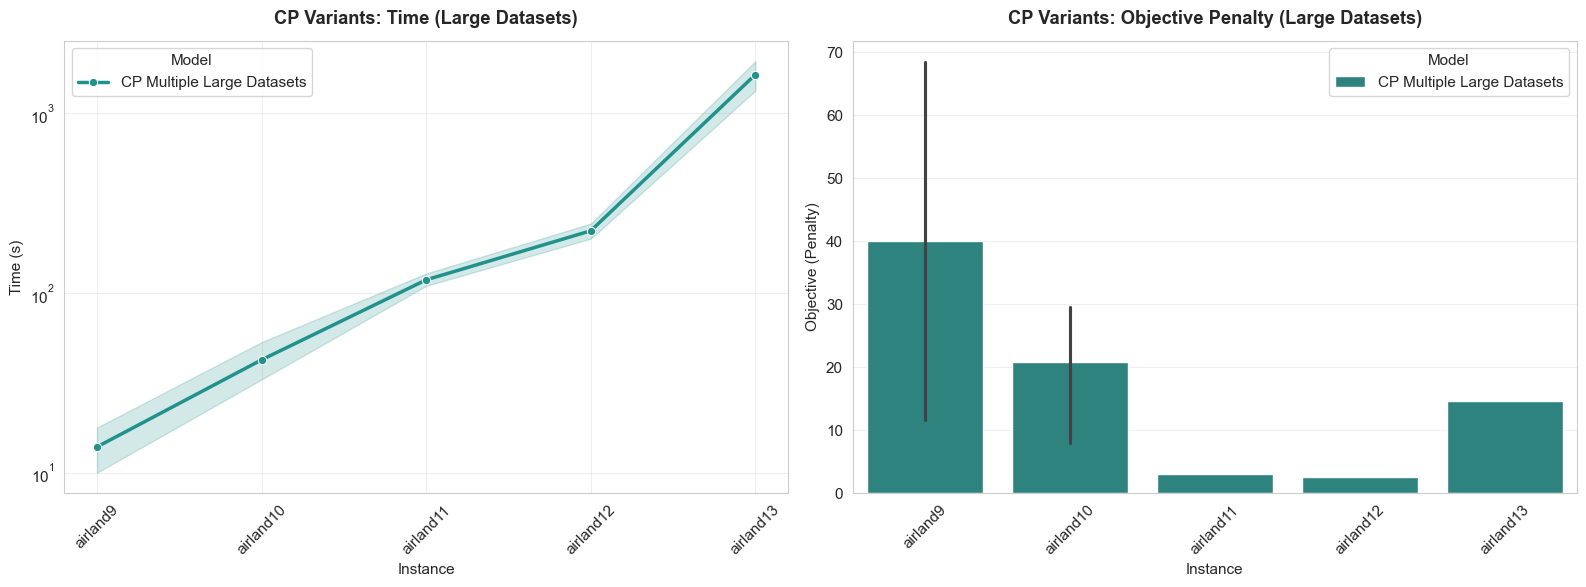

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import re

%matplotlib inline 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# 1. CARREGAR DADOS
with open('results/metrics.json', 'r') as f:
    data = json.load(f)

rows = []
for model_name, instances in data.items():
    for inst in instances:
        file_name = inst.get("file", "").replace(".txt", "")
        match = re.search(r'\d+', file_name)
        instance_id = int(match.group()) if match else 0
        
        exec_time = inst.get("execution_time") or inst.get("total_time", 0)
        mem_usage = inst.get("memory_usage_MB") or inst.get("memory_usage", 0)
        penalty = inst.get("total_penalty") or inst.get("best_objective_bound", 0)
        
        # Categorização para filtragem fácil
        family = "MIP" if "MIP" in model_name else ("CP" if "CP" in model_name else "Hybrid")
        mode = "Single" if "Single" in model_name else ("Multiple" in model_name and "Large" not in model_name)
        
        rows.append({
            "Model": model_name,
            "Family": family, # MIP, CP, Hybrid
            "Instance": file_name,
            "ID": instance_id,
            "Time (s)": exec_time,
            "Memory (MB)": mem_usage,
            "Objective (Penalty)": penalty
        })

df_all = pd.DataFrame(rows)

# ---------------------------------------------------------
# FUNÇÃO: HEAD-TO-HEAD (MIP vs CP)
# ---------------------------------------------------------
def plot_head_to_head(df, group_name):
    if df.empty: return
    print(f"\n>>> HEAD-TO-HEAD COMPARISON: {group_name} <<<\n")
    
    # Filtra apenas Single e Multiple (Ignora Hybrid ou Large específicos para agora)
    # Procuramos pares exatos: "MIP Single" vs "CP Single"
    models_interest = ["MIP Single", "CP Single", "MIP Multiple", "CP Multiple"]
    subset = df[df["Model"].isin(models_interest)]
    
    if subset.empty:
        print("Dados insuficientes para Head-to-Head.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. TEMPO
    sns.barplot(data=subset, x="Instance", y="Time (s)", hue="Model", ax=axes[0], palette="Paired")
    axes[0].set_yscale("log")
    axes[0].set_title(f"Time: MIP vs CP ({group_name})", fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. MEMÓRIA
    sns.barplot(data=subset, x="Instance", y="Memory (MB)", hue="Model", ax=axes[1], palette="Paired")
    axes[1].set_title(f"Memory: MIP vs CP ({group_name})", fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# FUNÇÃO: INTRA-MODEL EVOLUTION (Single vs Multi vs Large)
# ---------------------------------------------------------
def plot_intra_evolution(df, family, group_name):
    # Filtra pela familia (Ex: Só MIPs ou Só CPs)
    subset = df[df["Family"] == family]
    if subset.empty: return
    
    print(f"\n>>> {family} EVOLUTION: {group_name} <<<\n")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Usamos lineplot para ver a tendência de crescimento entre variantes
    # 1. TEMPO
    sns.lineplot(data=subset, x="Instance", y="Time (s)", hue="Model", style="Model", markers=True, ax=axes[0], palette="viridis", linewidth=2.5)
    axes[0].set_yscale("log")
    axes[0].set_title(f"{family} Variants: Time ({group_name})", fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. OBJECTIVE FUNCTION (PENALTY) - SANITY CHECK
    # Este gráfico serve para ver se o Multiple consegue penalidades menores que o Single
    sns.barplot(data=subset, x="Instance", y="Objective (Penalty)", hue="Model", ax=axes[1], palette="viridis")
    axes[1].set_title(f"{family} Variants: Objective Penalty ({group_name})", fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# EXECUTAR POR GRUPOS
# ---------------------------------------------------------

# --- GRUPO 1: 1-8 ---
df_1 = df_all[(df_all["ID"] >= 1) & (df_all["ID"] <= 8)]

if not df_1.empty:
    plot_head_to_head(df_1, "Small Datasets")
    plot_intra_evolution(df_1, "MIP", "Small Datasets")
    plot_intra_evolution(df_1, "CP", "Small Datasets")

# --- GRUPO 2: 9-13 ---
df_2 = df_all[(df_all["ID"] >= 9) & (df_all["ID"] <= 13)]

if not df_2.empty:
    plot_head_to_head(df_2, "Large Datasets")
    plot_intra_evolution(df_2, "MIP", "Large Datasets")
    plot_intra_evolution(df_2, "CP", "Large Datasets")


==================== ANÁLISE MIP: Small/Medium Datasets ====================



C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\1577359131.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="Instance", y="Count", hue="Type", ci=None, palette="viridis", ax=ax1)


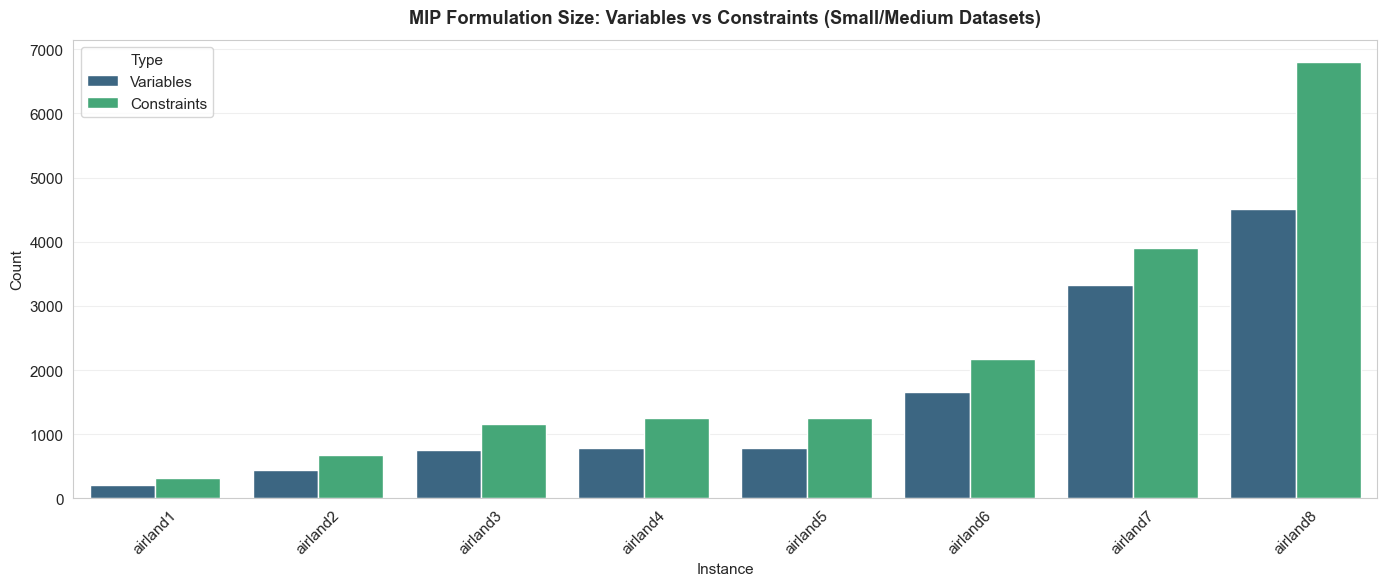

C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\1577359131.py:78: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df, x="Instance", y="Nodes", hue="Model", ax=ax2_twin, palette="Reds", markers="D", scale=0.7)


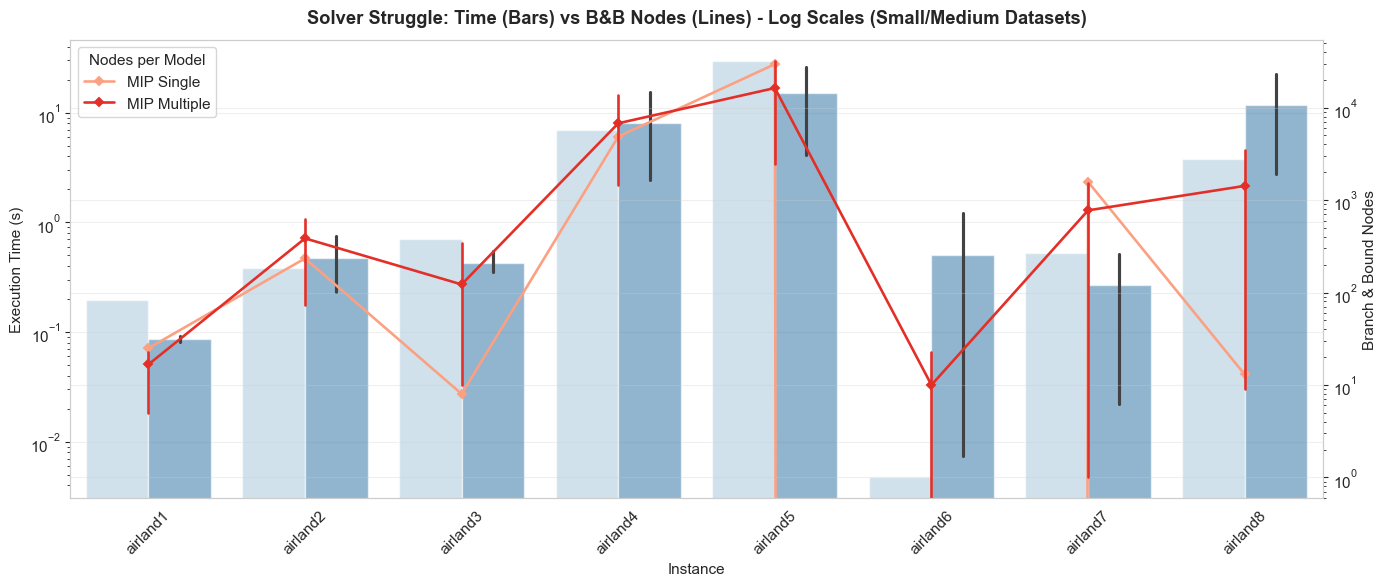

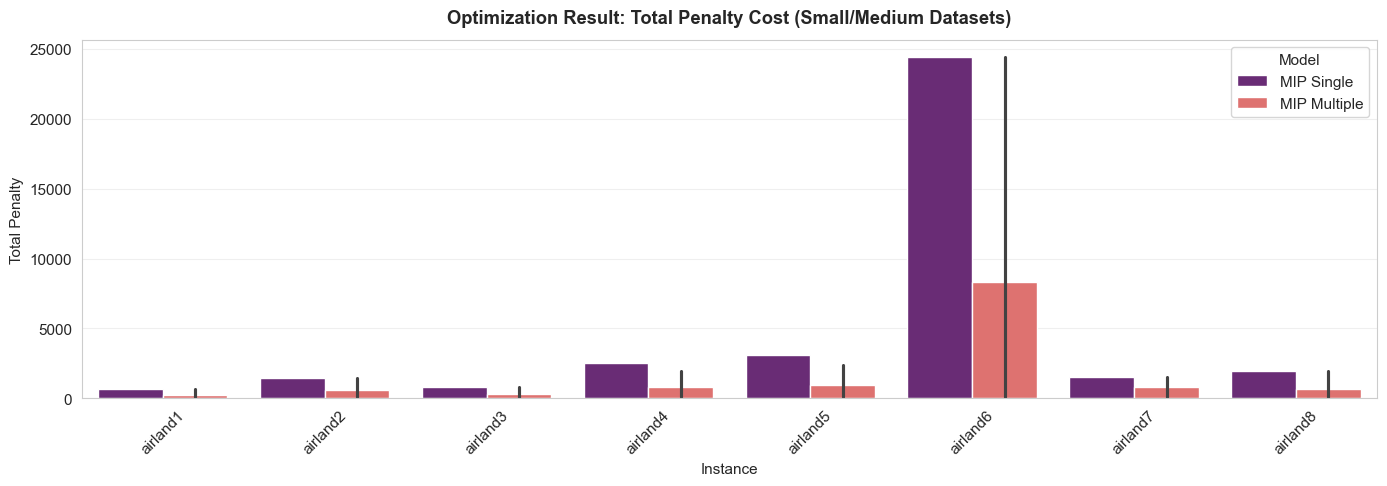


==================== ANÁLISE MIP: Large Datasets ====================



C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\1577359131.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="Instance", y="Count", hue="Type", ci=None, palette="viridis", ax=ax1)


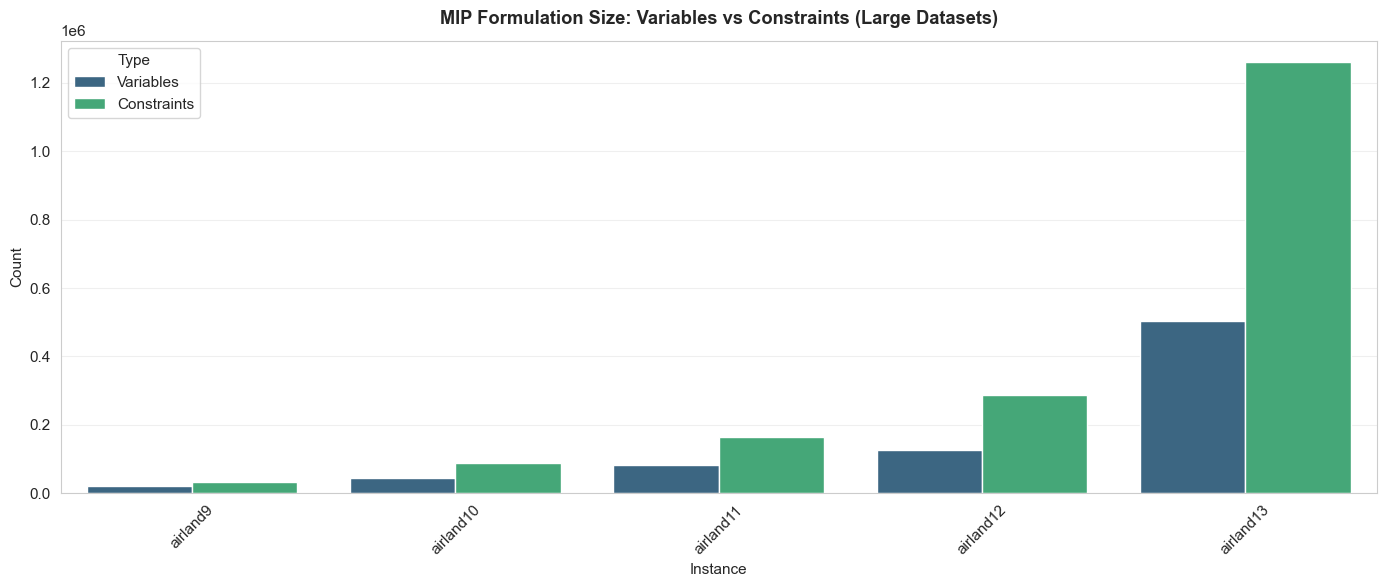

C:\Users\Patyc\AppData\Local\Temp\ipykernel_3180\1577359131.py:78: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df, x="Instance", y="Nodes", hue="Model", ax=ax2_twin, palette="Reds", markers="D", scale=0.7)


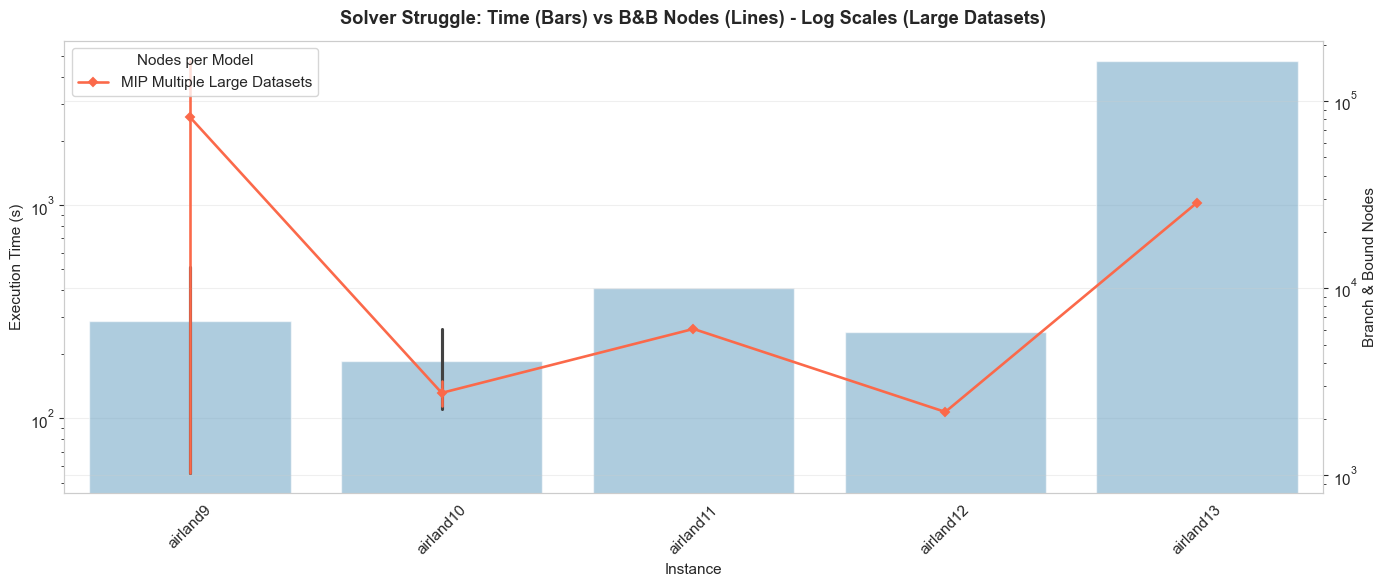

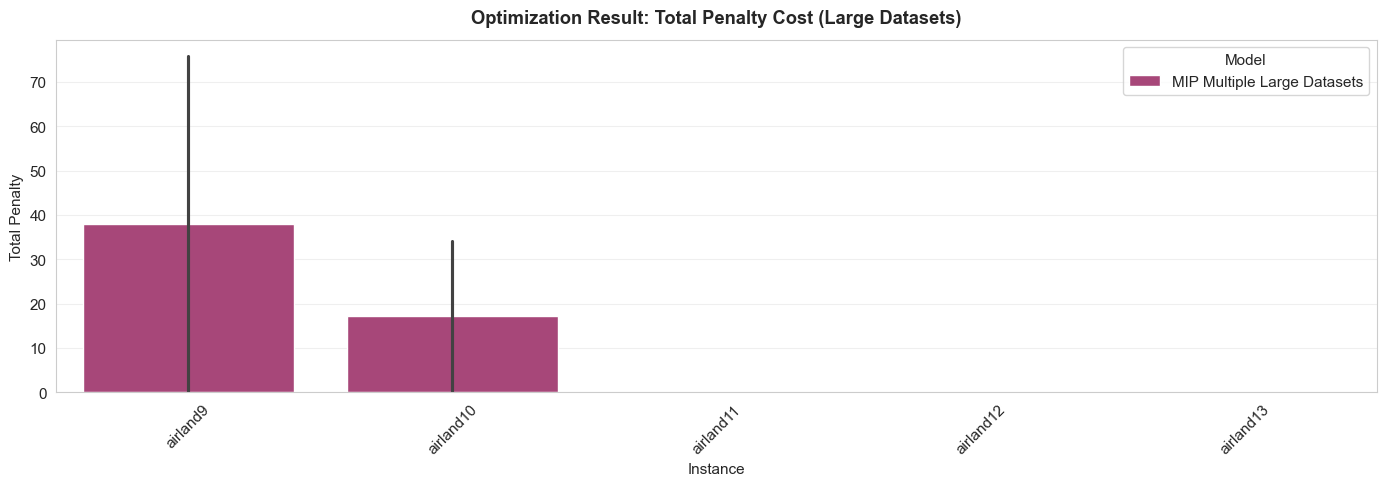

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import re

%matplotlib inline 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# 1. CARREGAR DADOS
with open('results/metrics.json', 'r') as f:
    data = json.load(f)

rows = []
for model_name, instances in data.items():
    # Filtrar APENAS modelos MIP
    if "MIP" not in model_name:
        continue
        
    for inst in instances:
        file_name = inst.get("file", "").replace(".txt", "")
        match = re.search(r'\d+', file_name)
        instance_id = int(match.group()) if match else 0
        
        rows.append({
            "Model": model_name,
            "Instance": file_name,
            "ID": instance_id,
            "Variables": inst.get("num_variables", 0),
            "Constraints": inst.get("num_constraints", 0),
            "Nodes": inst.get("num_branch_and_bound_nodes", 0),
            "Time (s)": inst.get("execution_time", 0),
            "Penalty": inst.get("total_penalty", 0)
        })

df_mip = pd.DataFrame(rows)

# ---------------------------------------------------------
# FUNÇÃO DE PLOTAGEM MIP
# ---------------------------------------------------------
def plot_mip_deep_dive(df, group_title):
    if df.empty: return
    print(f"\n{'='*20} ANÁLISE MIP: {group_title} {'='*20}\n")
    
    # --- GRÁFICO 1: MATRIZ SIZE (Stacked Bar) ---
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    
    # Preparar dados para stacked bar
    # Selecionamos apenas uma variante (ex: Single) para ver o tamanho base do problema
    # ou mostramos todas lado a lado. Vamos mostrar lado a lado para veres se o Multiple aumenta muito.
    
    df_melted = df.melt(id_vars=["Instance", "Model"], value_vars=["Variables", "Constraints"], var_name="Type", value_name="Count")
    
    sns.barplot(data=df_melted, x="Instance", y="Count", hue="Type", ci=None, palette="viridis", ax=ax1)
    ax1.set_title(f"MIP Formulation Size: Variables vs Constraints ({group_title})", fontweight='bold')
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 2: ESFORÇO DE PROVA (Time vs Nodes) ---
    # Este é um Dual Axis chart
    instances = df["Instance"].unique()
    # Vamos focar no modelo "MIP Single" como base, ou plotar scatter se houverem vários
    
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    
    # Bar plot para Tempo (Eixo Esquerdo)
    sns.barplot(data=df, x="Instance", y="Time (s)", hue="Model", ax=ax2, palette="Blues", alpha=0.6)
    ax2.set_ylabel("Execution Time (s)")
    ax2.set_yscale("log") # Tempo em log
    
    # Line plot para Nós (Eixo Direito)
    ax2_twin = ax2.twinx()
    sns.pointplot(data=df, x="Instance", y="Nodes", hue="Model", ax=ax2_twin, palette="Reds", markers="D", scale=0.7)
    ax2_twin.set_ylabel("Branch & Bound Nodes")
    ax2_twin.set_yscale("log") # Nós em log também, pois variam muito
    
    ax2.set_title(f"Solver Struggle: Time (Bars) vs B&B Nodes (Lines) - Log Scales ({group_title})", fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # Ajustar legendas para não sobrepor
    ax2.get_legend().remove()
    ax2_twin.legend(title="Nodes per Model", loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 3: CUSTO DA SOLUÇÃO (Penalty) ---
    fig3, ax3 = plt.subplots(figsize=(14, 5))
    sns.barplot(data=df, x="Instance", y="Penalty", hue="Model", palette="magma", ax=ax3)
    ax3.set_title(f"Optimization Result: Total Penalty Cost ({group_title})", fontweight='bold')
    ax3.set_ylabel("Total Penalty")
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# EXECUTAR
# ---------------------------------------------------------

# Grupo 1: 1-8
df_small = df_mip[(df_mip["ID"] >= 1) & (df_mip["ID"] <= 8)]
plot_mip_deep_dive(df_small, "Small/Medium Datasets")

# Grupo 2: 9-13
df_large = df_mip[(df_mip["ID"] >= 9) & (df_mip["ID"] <= 13)]
plot_mip_deep_dive(df_large, "Large Datasets")


==================== ANÁLISE CP: Small/Medium Datasets ====================



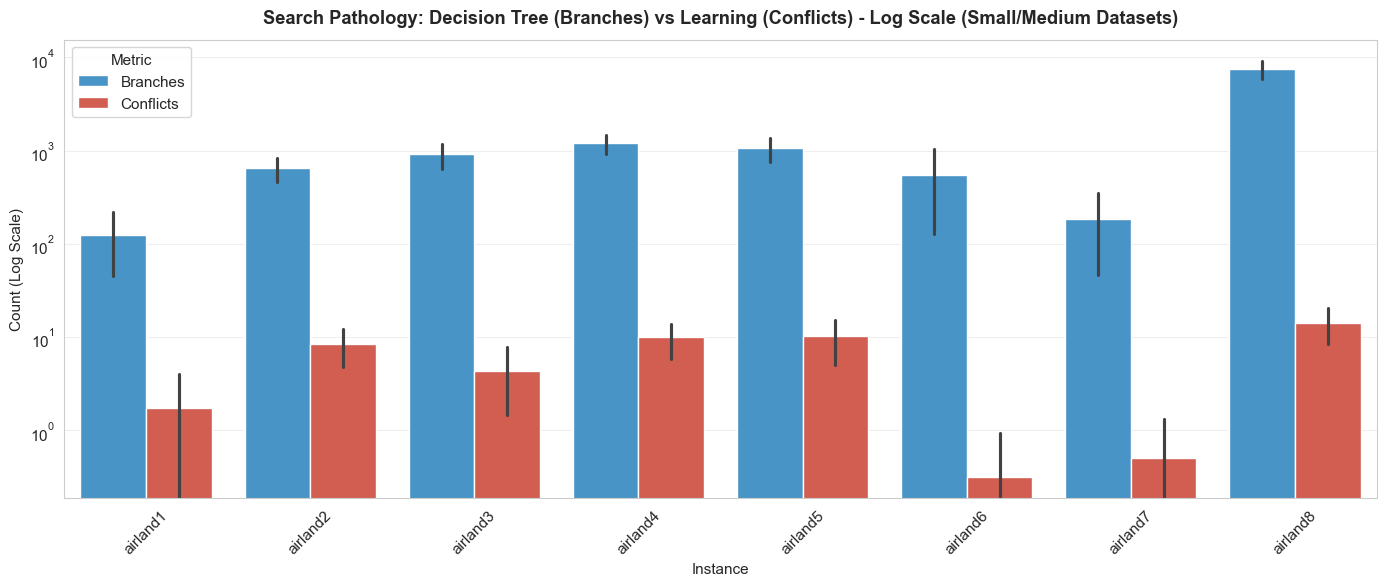

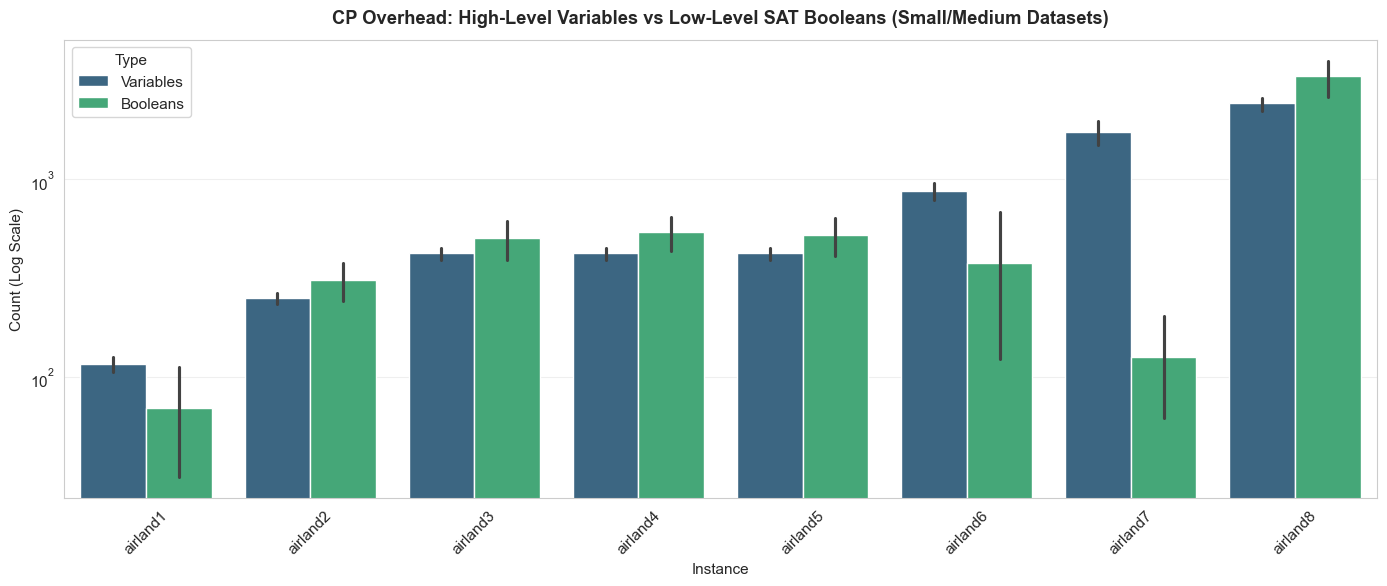

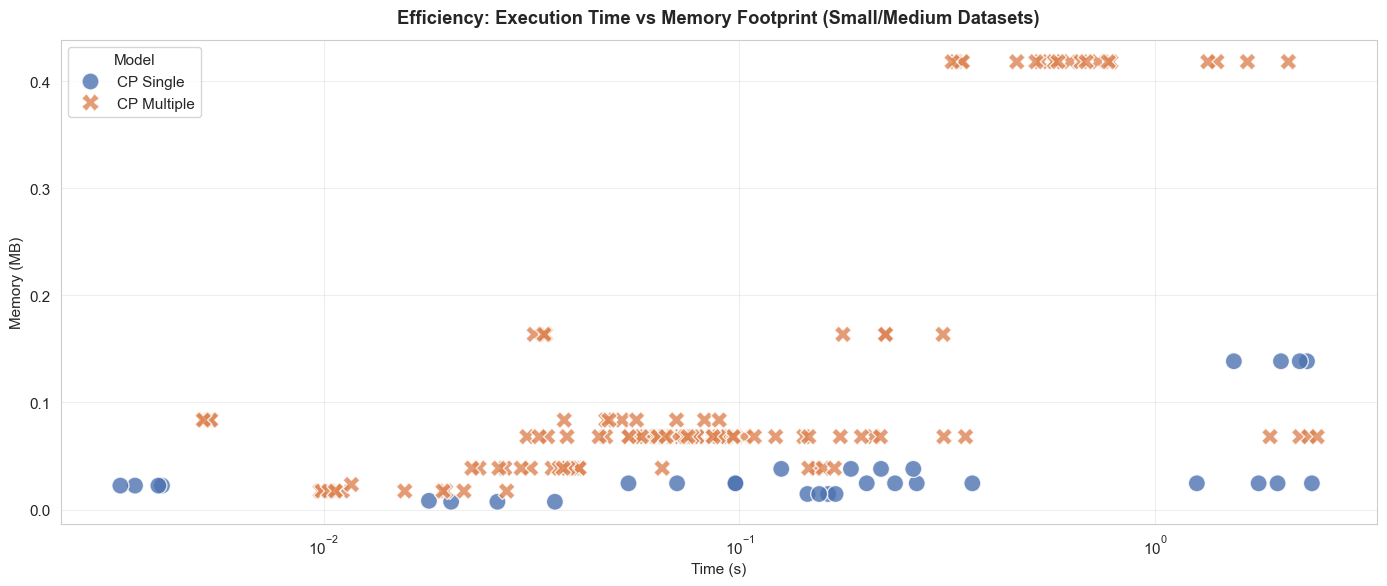


==================== ANÁLISE CP: Large Datasets ====================



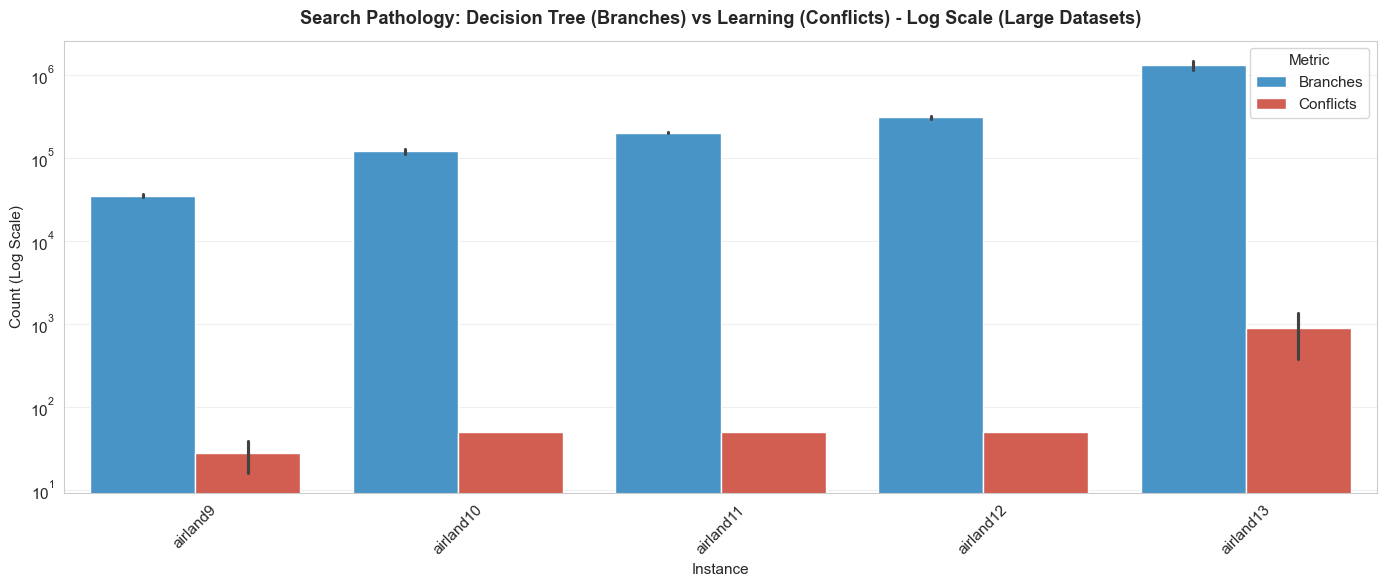

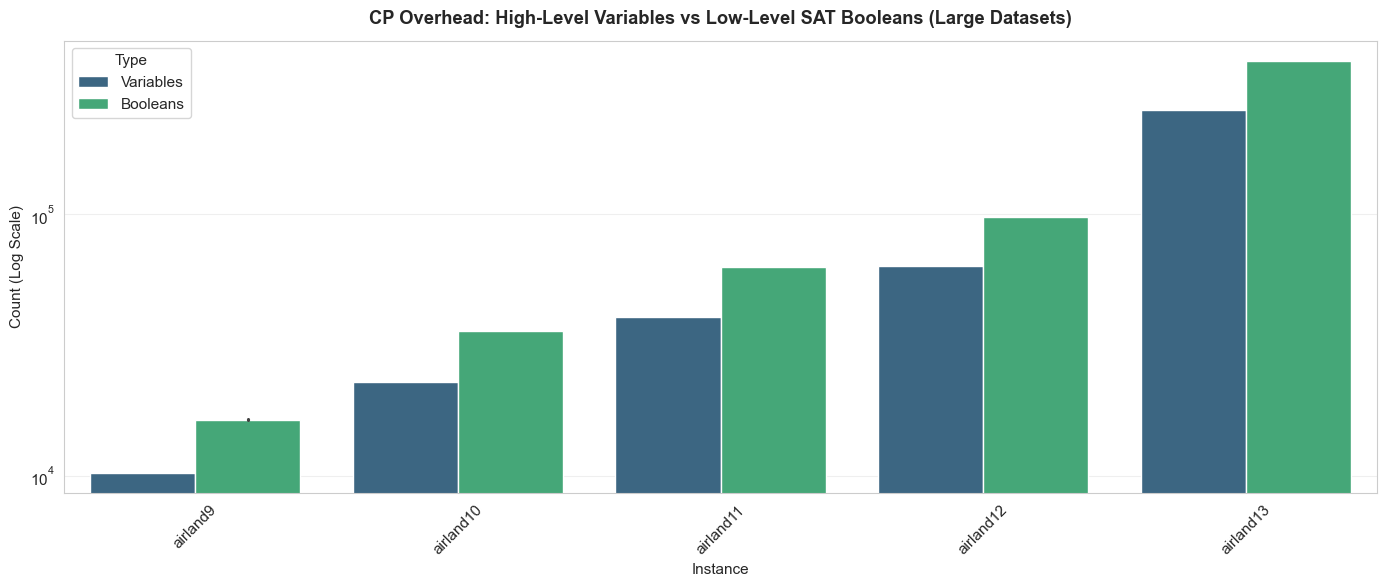

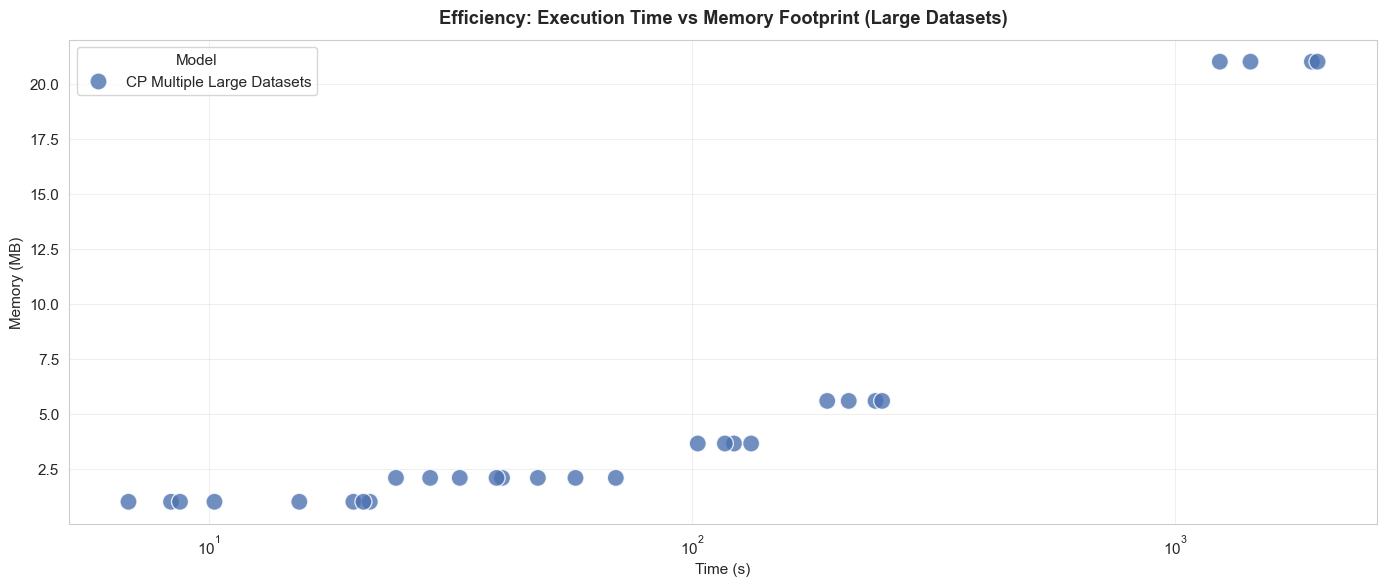

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import re

%matplotlib inline 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# 1. CARREGAR DADOS
with open('results/metrics.json', 'r') as f:
    data = json.load(f)

rows = []
for model_name, instances in data.items():
    # Filtrar APENAS modelos CP
    if "CP" not in model_name:
        continue
        
    for inst in instances:
        file_name = inst.get("file", "").replace(".txt", "")
        match = re.search(r'\d+', file_name)
        instance_id = int(match.group()) if match else 0
        
        # Tratamento de zeros para evitar erros em escalas log
        branches = inst.get("num_branches", 0)
        conflicts = inst.get("num_conflicts", 0)
        
        rows.append({
            "Model": model_name,
            "Instance": file_name,
            "ID": instance_id,
            "Variables": inst.get("num_variables", 0),
            "Constraints": inst.get("num_constraints", 0),
            "Booleans": inst.get("num_booleans", 0), # Métrica específica CP/SAT
            "Branches": branches,
            "Conflicts": conflicts,
            "Time (s)": inst.get("execution_time", 0),
            "Memory (MB)": inst.get("memory_usage", inst.get("memory_usage_MB", 0))
        })

df_cp = pd.DataFrame(rows)

# ---------------------------------------------------------
# FUNÇÃO DE PLOTAGEM CP
# ---------------------------------------------------------
def plot_cp_deep_dive(df, group_title):
    if df.empty: return
    print(f"\n{'='*20} ANÁLISE CP: {group_title} {'='*20}\n")
    
    # --- GRÁFICO 1: SEARCH PATHOLOGY (Branches vs Conflicts) ---
    # Este gráfico mostra se o solver está "perdido" (só branches) ou a "lutar" (conflicts)
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    
    # Dual Axis
    width = 0.35
    x = range(len(df["Instance"].unique()))
    instances = df["Instance"].unique()
    
    # Para simplificar a visualização lado a lado, usamos melt ou plotamos para o primeiro modelo encontrado
    # Se houver CP Single e CP Multiple, vamos focar a comparação visual usando scatter ou barplot agrupado
    
    # Opção Scatter para ver a magnitude (Log Scale)
    df_melted_search = df.melt(id_vars=["Instance", "Model"], value_vars=["Branches", "Conflicts"], var_name="Metric", value_name="Count")
    
    sns.barplot(data=df_melted_search, x="Instance", y="Count", hue="Metric", palette={"Branches": "#3498db", "Conflicts": "#e74c3c"}, ax=ax1)
    
    ax1.set_yscale("log") # CRÍTICO: Conflicts pode ser 0 ou 10, Branches pode ser 1 milhão
    ax1.set_title(f"Search Pathology: Decision Tree (Branches) vs Learning (Conflicts) - Log Scale ({group_title})", fontweight='bold')
    ax1.set_ylabel("Count (Log Scale)")
    ax1.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 2: SAT ENCODING IMPACT (Variables vs Booleans) ---
    # Mostra a "inflação" do problema ao ser traduzido para SAT
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    
    # Vamos usar duas cores: Uma para variáveis base, outra para booleanos (que são muito mais)
    # Como os booleanos são muito maiores, usamos eixo duplo ou log scale. Vamos de Log Scale.
    
    df_melted_vars = df.melt(id_vars=["Instance", "Model"], value_vars=["Variables", "Booleans"], var_name="Type", value_name="Count")
    
    sns.barplot(data=df_melted_vars, x="Instance", y="Count", hue="Type", palette="viridis", ax=ax2)
    
    ax2.set_yscale("log")
    ax2.set_title(f"CP Overhead: High-Level Variables vs Low-Level SAT Booleans ({group_title})", fontweight='bold')
    ax2.set_ylabel("Count (Log Scale)")
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 3: PERFORMANCE PROFILE (Time vs Memory) ---
    fig3, ax3 = plt.subplots(figsize=(14, 6))
    
    sns.scatterplot(data=df, x="Time (s)", y="Memory (MB)", hue="Model", style="Model", s=150, alpha=0.8, palette="deep", ax=ax3)
    
    ax3.set_xscale("log") # Tempo em log
    # ax3.set_yscale("log") # Memória nem sempre precisa, mas se variar muito, descomenta
    
    ax3.set_title(f"Efficiency: Execution Time vs Memory Footprint ({group_title})", fontweight='bold')
    # Adicionar labels nos pontos para saber qual instância é qual (opcional, pode poluir se forem muitos pontos)
    if len(df) < 15:
        for i in range(df.shape[0]):
            ax3.text(df["Time (s)"].iloc[i], df["Memory (MB)"].iloc[i], df["Instance"].iloc[i], fontsize=9, alpha=0.7)

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# EXECUTAR
# ---------------------------------------------------------

# Grupo 1: 1-8
df_cp_small = df_cp[(df_cp["ID"] >= 1) & (df_cp["ID"] <= 8)]
plot_cp_deep_dive(df_cp_small, "Small/Medium Datasets")

# Grupo 2: 9-13
df_cp_large = df_cp[(df_cp["ID"] >= 9) & (df_cp["ID"] <= 13)]
plot_cp_deep_dive(df_cp_large, "Large Datasets")